In [46]:
###############################################################
#-------------------------------------------------------------#
#####           AirBnB NYC - Machine Learning            ######
#-------------------------------------------------------------#
###############################################################

library(tidyverse)
library(lubridate)
library(ggcorrplot)
library(lattice)
library(psych)
library(DataExplorer)
library(reshape2)
library(car)
library(caret)
library(cowplot)
library(caTools)
library(rpart.plot)
library(e1071)
library(leaps)
library(rpart)
library(randomForest)
library(scales)
library(RColorBrewer)
library(packHV)
options(warn=-1)
#par(mfrow=c(1,1))

In [15]:
df <- read_csv("../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv")

Parsed with column specification:
cols(
  id = col_double(),
  name = col_character(),
  host_id = col_double(),
  host_name = col_character(),
  neighbourhood_group = col_character(),
  neighbourhood = col_character(),
  latitude = col_double(),
  longitude = col_double(),
  room_type = col_character(),
  price = col_double(),
  minimum_nights = col_double(),
  number_of_reviews = col_double(),
  last_review = col_date(format = ""),
  reviews_per_month = col_double(),
  calculated_host_listings_count = col_double(),
  availability_365 = col_double()
)



In [16]:
# order the columns with target variable first
df <- df %>% select(price, # place target variable first
                    #id,
                    #name,                          
                    #host_id,
                    #host_name,
                    neighbourhood_group,
                    #neighbourhood,                 
                    latitude, 
                    longitude,                     
                    room_type,                                               
                    minimum_nights, 
                    number_of_reviews,             
                    #last_review, 
                    reviews_per_month,             
                    calculated_host_listings_count,
                    availability_365)

#-------------------------------------------#
###########    Missing values    ############
#-------------------------------------------#

#plot_missing(df) + theme_bw()
#  Replace NA's in the original dataframe
df$reviews_per_month[is.na(df$reviews_per_month)] <- 0
#sum(is.na(df))

#--------------------------------------#
#######        Data Types        #######
#--------------------------------------#

columns <- c("neighbourhood_group","room_type")
df[, columns] <- df %>% select(all_of(columns)) %>% lapply(as.factor)
# check to make sure it worked
df %>% select(all_of(columns)) %>% str()
df %>% head(5)

tibble [48,895 × 2] (S3: tbl_df/tbl/data.frame)
 $ neighbourhood_group: Factor w/ 5 levels "Bronx","Brooklyn",..: 2 3 3 2 3 3 2 3 3 3 ...
 $ room_type          : Factor w/ 3 levels "Entire home/apt",..: 2 1 2 1 1 1 2 2 2 1 ...


price,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
149,Brooklyn,40.64749,-73.97237,Private room,1,9,0.21,6,365
225,Manhattan,40.75362,-73.98377,Entire home/apt,1,45,0.38,2,355
150,Manhattan,40.80902,-73.94190,Private room,3,0,0.00,1,365
89,Brooklyn,40.68514,-73.95976,Entire home/apt,1,270,4.64,1,194
80,Manhattan,40.79851,-73.94399,Entire home/apt,10,9,0.10,1,0


In [17]:
###############################################################
#-------------------------------------------------------------#
###    Data Distributions - Is data normally distributed?  ####
#-------------------------------------------------------------#
###############################################################

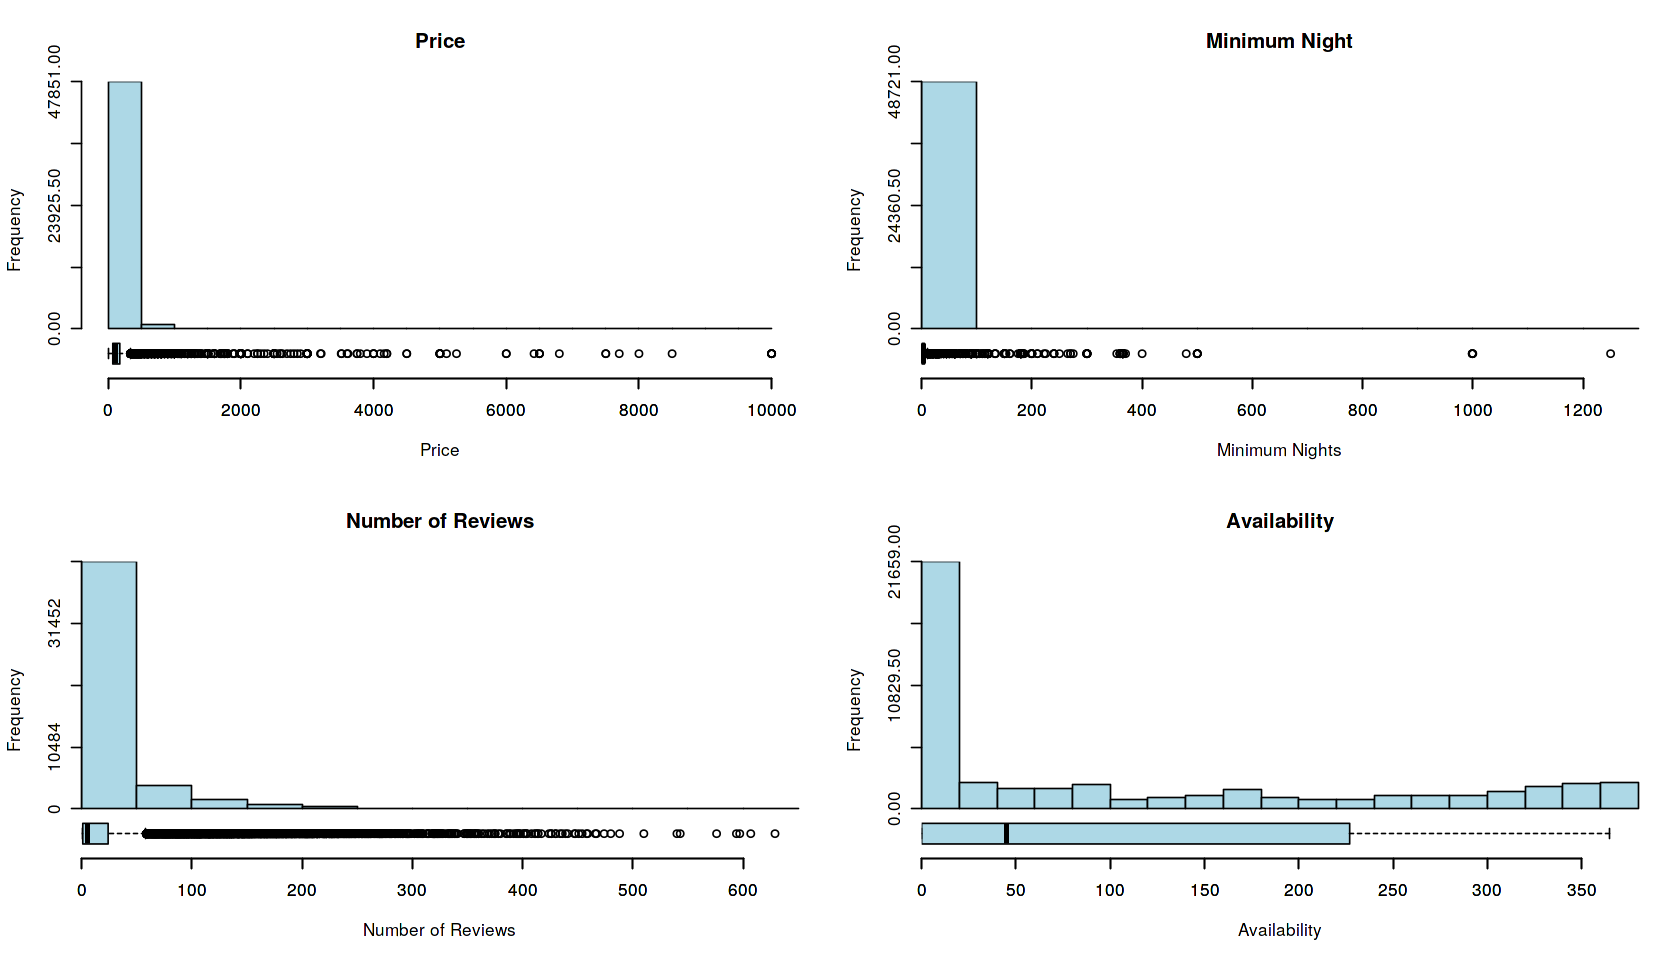

In [18]:
par(mfrow=c(2,2))
options(repr.plot.width=14, repr.plot.height=8)
hist_boxplot(df$price, main = "Price", col = "lightblue", xlab = "Price");
hist_boxplot(df$minimum_nights, main = "Minimum Night", col = "lightblue", xlab = "Minimum Nights");
hist_boxplot(df$number_of_reviews, main = "Number of Reviews", col = "lightblue",xlab = "Number of Reviews");
hist_boxplot(df$availability_365, main = "Availability", col = "lightblue", xlab = "Availability");
par(mfrow=c(1,1))

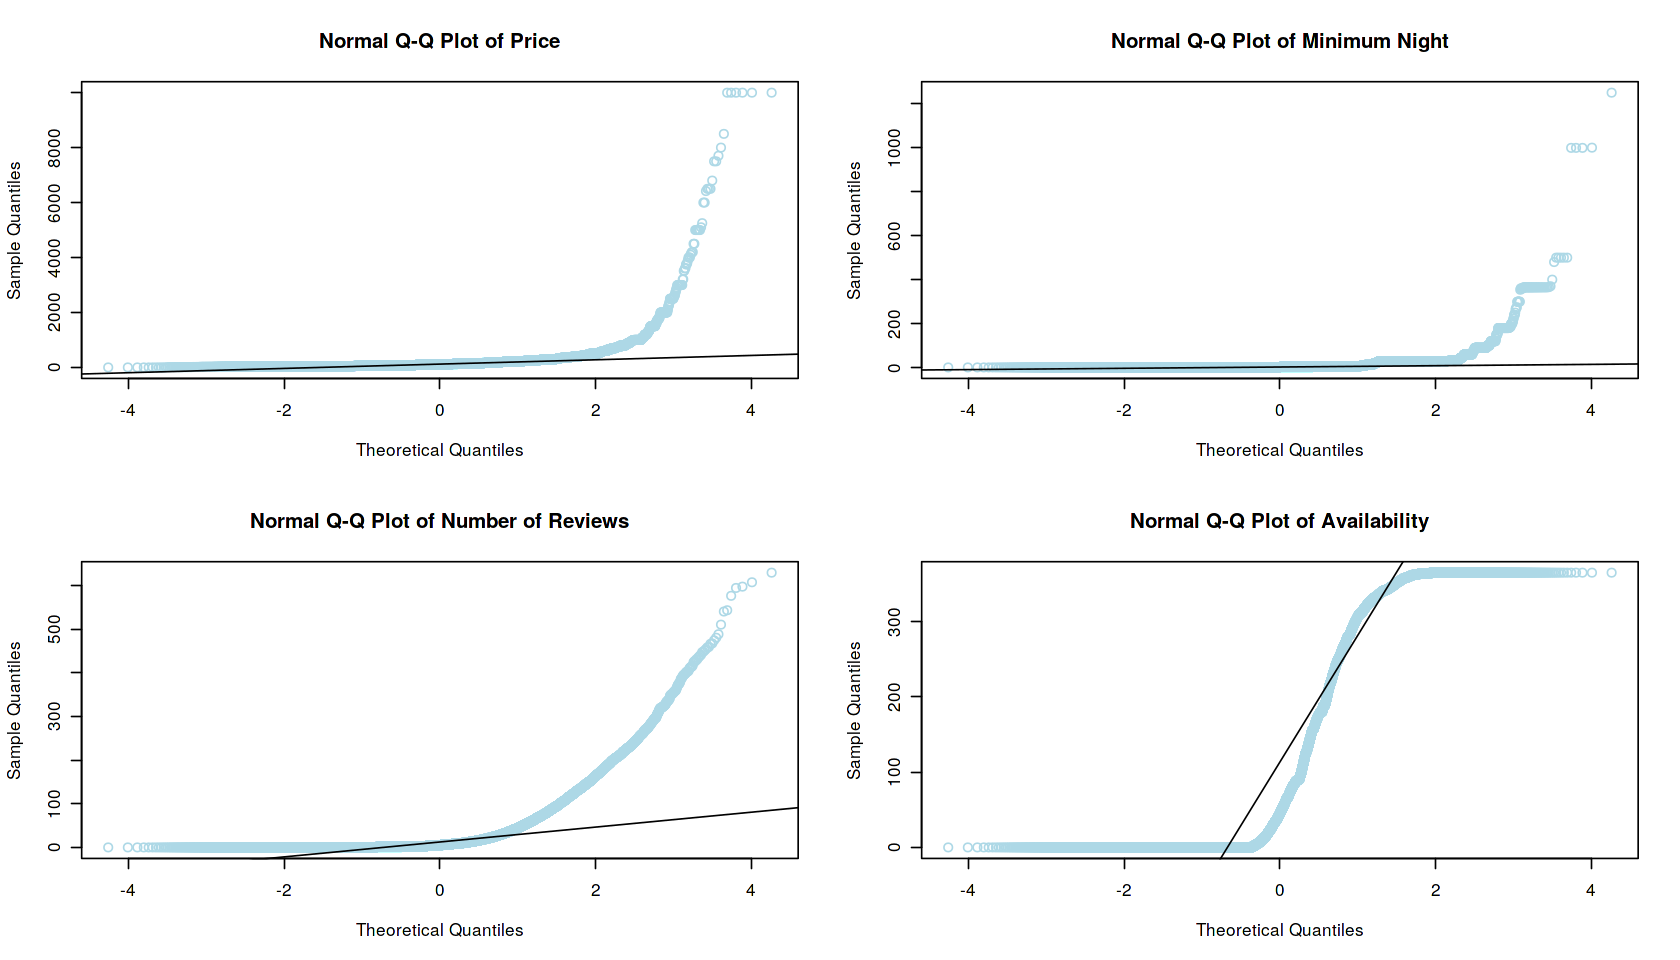

In [19]:
### ---   QQ-Plots ----- ###

par(mfrow=c(2,2))
#options(repr.plot.width=14, repr.plot.height=6)
qqnorm(df$price, main = "Normal Q-Q Plot of Price", col = "lightblue");qqline(df$price); 
qqnorm(df$minimum_nights, main = "Normal Q-Q Plot of Minimum Night", 
       col = "lightblue");qqline(df$minimum_nights); 
qqnorm(df$number_of_reviews, main = "Normal Q-Q Plot of Number of Reviews", 
       col = "lightblue",);qqline(df$number_of_reviews); 
qqnorm(df$availability_365, main = "Normal Q-Q Plot of Availability", 
       col = "lightblue");qqline(df$availability_365); 
par(mfrow=c(1,1))

In [20]:
#####    Skew of the Distirbutions     ######

# does skewness deviate a lot from 1 ?
skewness(df$price); 
skewness(df$minimum_nights); 
skewness(df$number_of_reviews);
skewness(df$availability_365); 

####    Shapiro Wilkes Test for Normality    ######

# Ho: data is normally distributed
s <- sample_n(df, 5000)
shapiro.test(s$price) # p-value < 2.2e-16 < 0.05 = not normaly distributed
shapiro.test(s$minimum_nights) # p-value < 2.2e-16 < 0.05 = not normaly distributed
shapiro.test(s$number_of_reviews) # p-value < 2.2e-16 < 0.05 = not normaly distributed
shapiro.test(s$availability_365) # p-value < 2.2e-16 < 0.05 = not normaly distributed
# p- value
# shapiro.test(df$price)[2]

[1] 19.11777

[1] 21.82594

[1] 3.690408

[1] 0.7633607


	Shapiro-Wilk normality test

data:  s$price
W = 0.30121, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  s$minimum_nights
W = 0.29757, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  s$number_of_reviews
W = 0.57759, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  s$availability_365
W = 0.78544, p-value < 2.2e-16


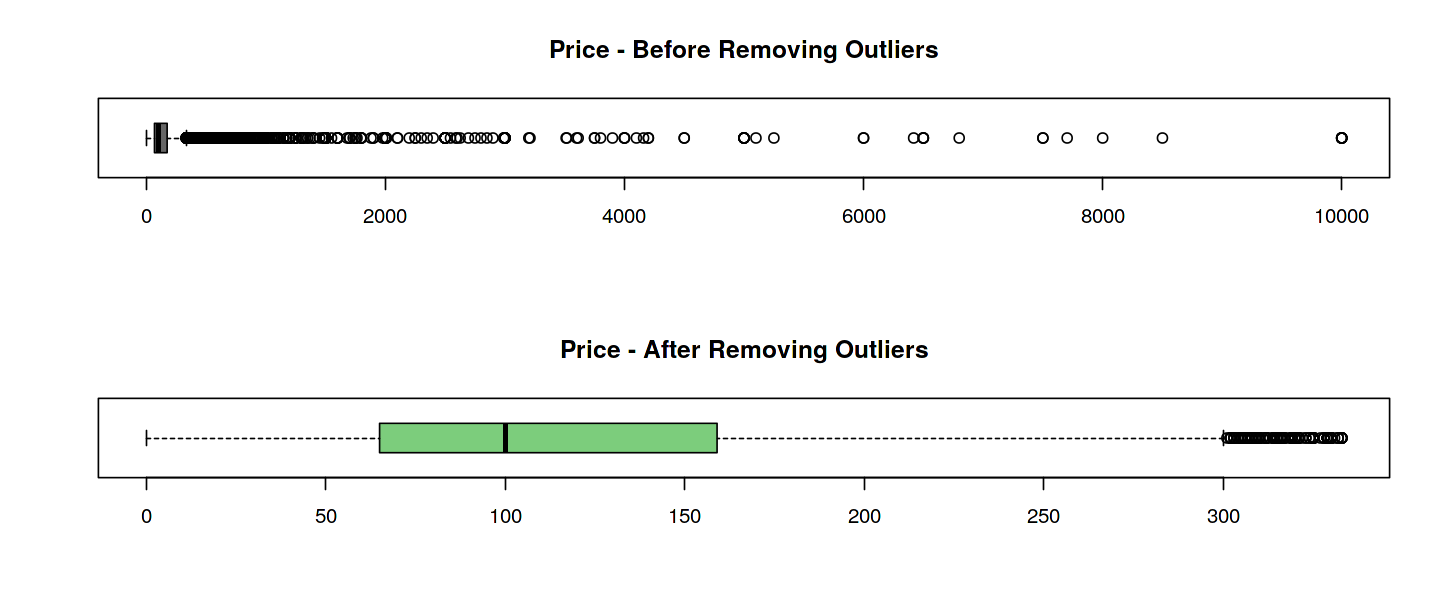

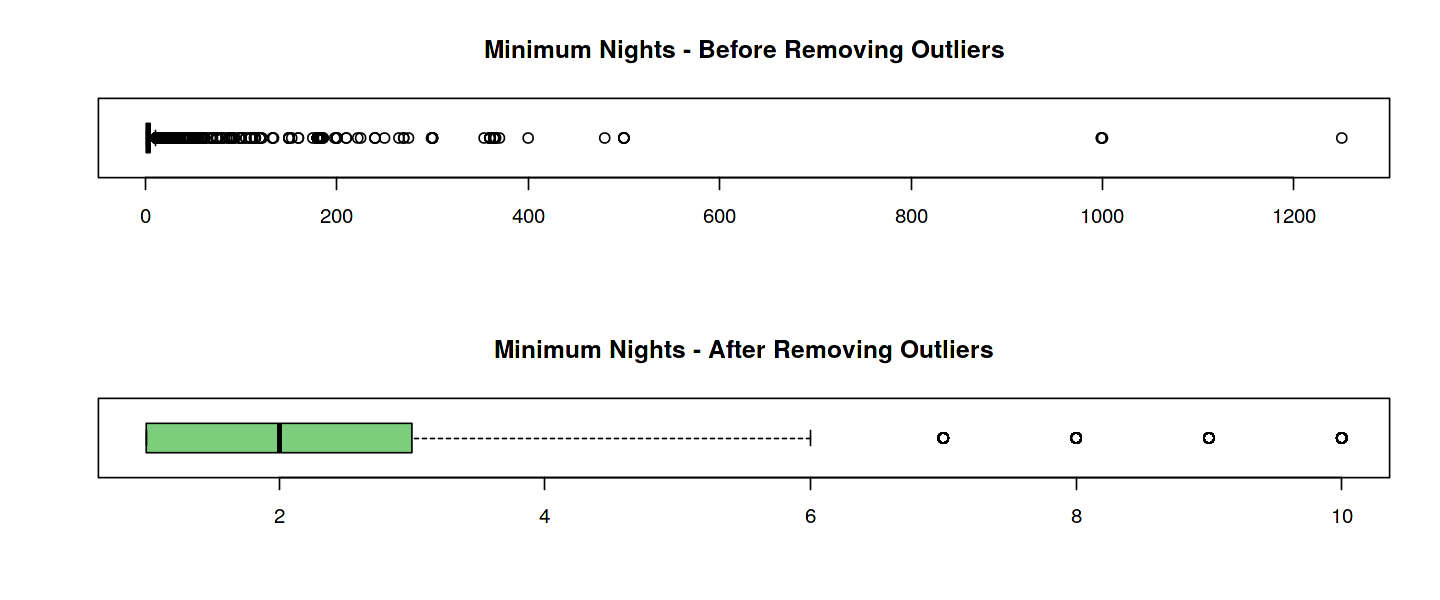

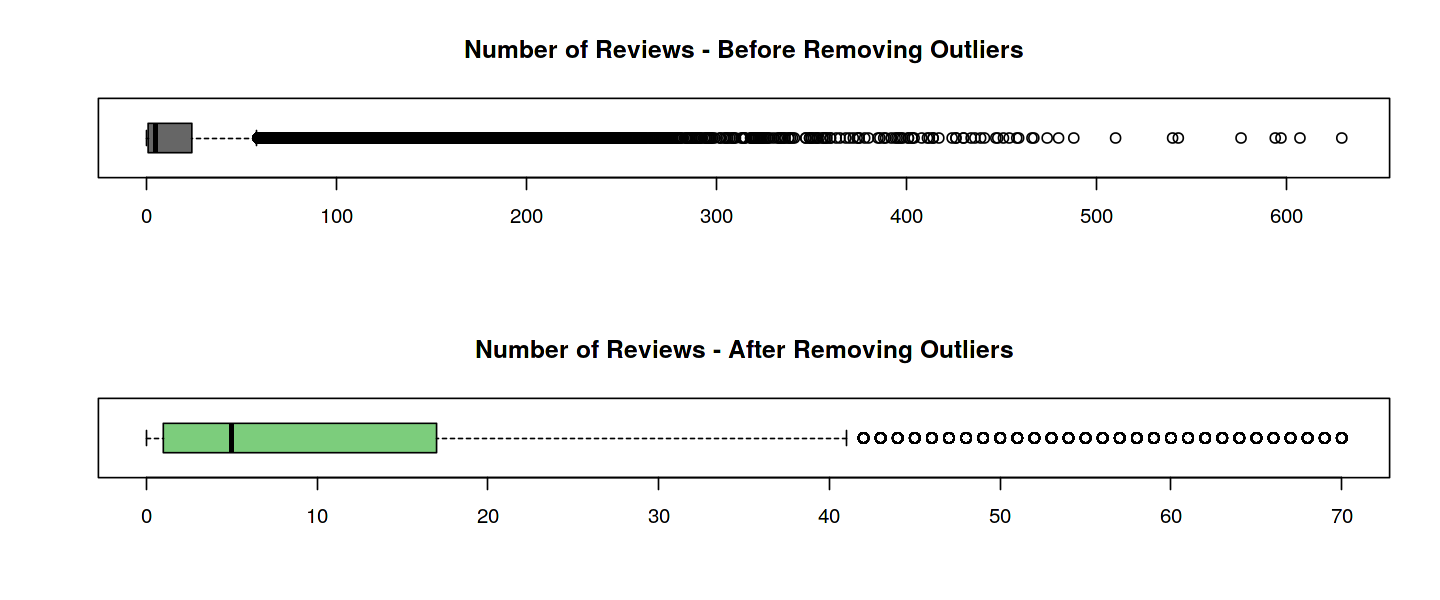

In [21]:
#-----------------------------------------------#
#####   Identify & Remove outliers - Price  #####
#-----------------------------------------------#

Q <- quantile(df$price, probs=c(.25, .75), na.rm = T)
iqr <- IQR(df$price, na.rm = T)
df2 <- df %>% filter(price > (Q[1] - 1.5*iqr) & 
                       price < (Q[2] + 1.5*iqr))  

# visualize the new dataset without outliers
par(mfrow=c(2,1))
options(repr.plot.width=12, repr.plot.height=5)
boxplot(df$price, col = "grey40", horizontal = T, 
        main = "Price - Before Removing Outliers")
boxplot(df2$price, col = "palegreen3", horizontal = T, 
        main = "Price - After Removing Outliers")

#--------------------------------------------------------#
#####   Identify & Remove outliers - Minimum Nights  #####
#--------------------------------------------------------#

Q <- quantile(df2$minimum_nights, probs=c(.25, .75), na.rm = T)
iqr <- IQR(df2$minimum_nights, na.rm = T)
df2 <- df2 %>% filter(minimum_nights > (Q[1] - 1.5*iqr) & 
                       minimum_nights < (Q[2] + 1.5*iqr))  

# visualize the new dataset without outliers
par(mfrow=c(2,1))
boxplot(df$minimum_nights, col = "grey40", horizontal = T, 
        main = "Minimum Nights - Before Removing Outliers")
boxplot(df2$minimum_nights, col = "palegreen3", horizontal = T, 
        main = "Minimum Nights - After Removing Outliers")

#-----------------------------------------------------------#
#####   Identify & Remove outliers - Number of Reviews  #####
#-----------------------------------------------------------#

Q <- quantile(df2$number_of_reviews, probs=c(.25, .75), na.rm = T)
iqr <- IQR(df2$number_of_reviews, na.rm = T)
df2 <- df2 %>% filter(number_of_reviews > (Q[1] - 1.5*iqr) & 
                        number_of_reviews < (Q[2] + 1.5*iqr))  

# visualize the new dataset without outliers
par(mfrow=c(2,1))
boxplot(df$number_of_reviews, col = "grey40", horizontal = T, 
        main = "Number of Reviews - Before Removing Outliers")
boxplot(df2$number_of_reviews, col = "palegreen3", horizontal = T, 
        main = "Number of Reviews - After Removing Outliers")

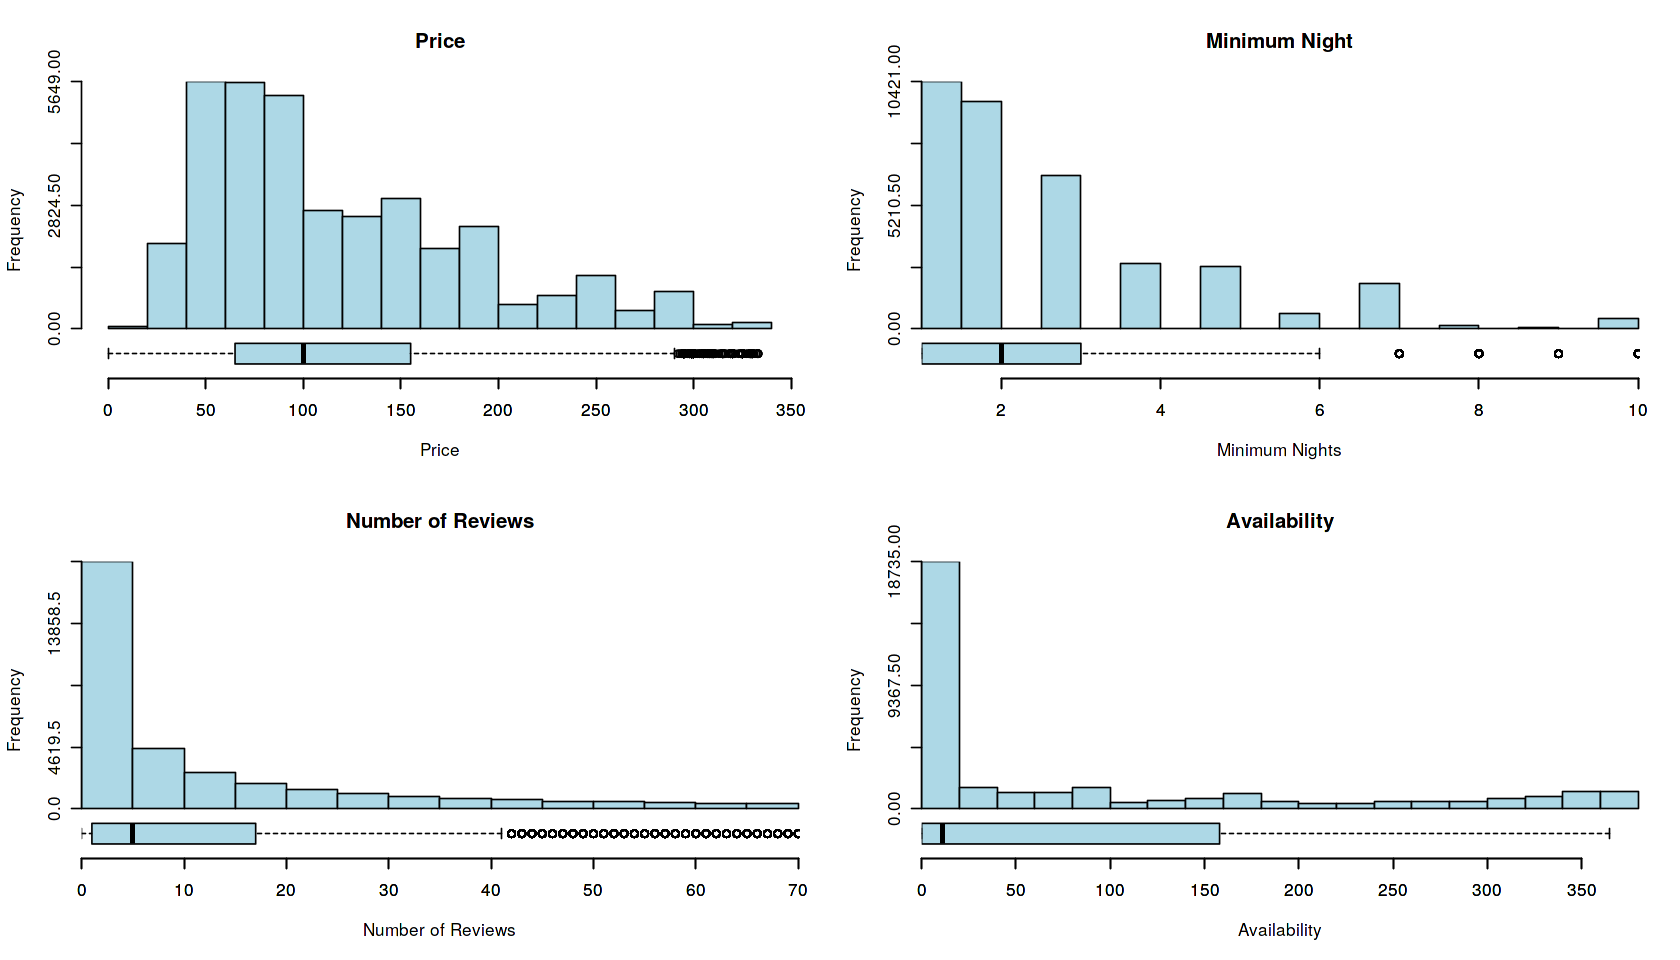

In [22]:
#-------------------------------------------------------------#
###    Data Distributions - Is data normally distributed?  ####
#-------------------------------------------------------------#

par(mfrow=c(2,2))
options(repr.plot.width=14, repr.plot.height=8)
hist_boxplot(df2$price, main = "Price", col = "lightblue", xlab = "Price");
hist_boxplot(df2$minimum_nights, main = "Minimum Night", col = "lightblue", xlab = "Minimum Nights");
hist_boxplot(df2$number_of_reviews, main = "Number of Reviews", col = "lightblue",xlab = "Number of Reviews");
hist_boxplot(df2$availability_365, main = "Availability", col = "lightblue", xlab = "Availability");
par(mfrow=c(1,1))

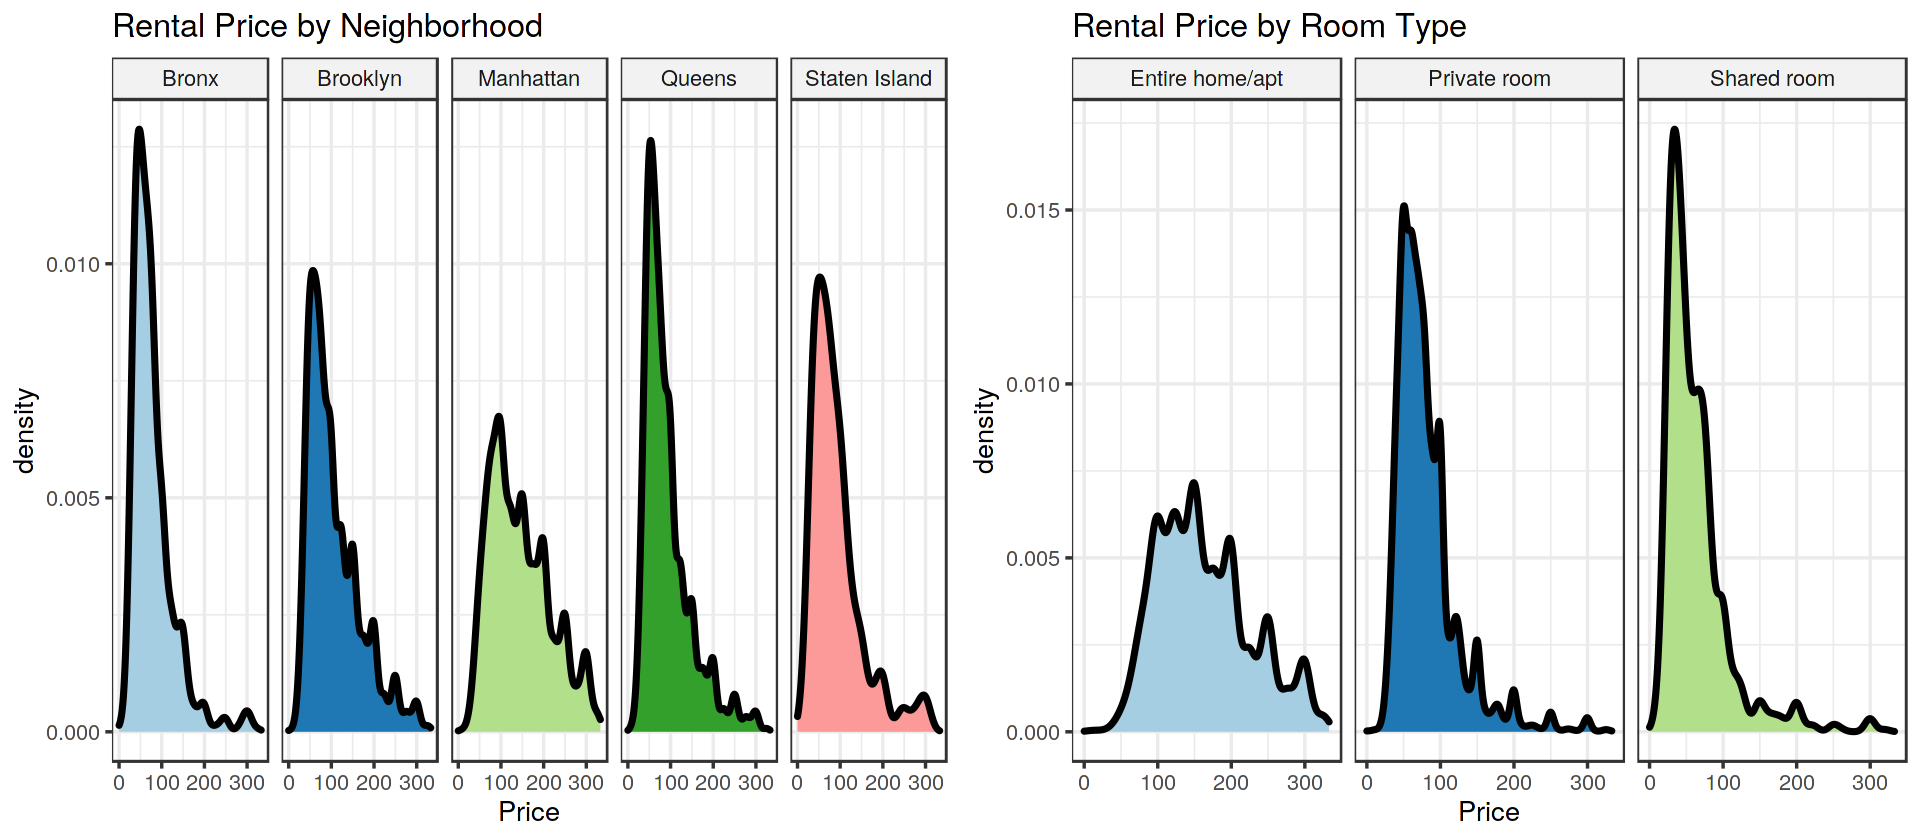

In [26]:
#-------------------------------------------#
######       Visualize the Data        ######
#-------------------------------------------#

# set the color palette
pal = brewer.pal(7, "Paired")
#pal = c("olivedrab3", 'yellow', 'orange', 'grey50')

# price by neighborhood

a = ggplot(df2, aes(price, fill = neighbourhood_group)) + 
  geom_density(show.legend = F, lwd = 1.5) + 
  scale_fill_manual(values=pal) + theme_bw(base_size = 16)  +
  labs(title = "Rental Price by Neighborhood", x = "Price") +
  facet_grid(~neighbourhood_group) +
  theme(strip.background = element_rect(fill="grey95"))

# price by room type
b = ggplot(df2, aes(price, fill = room_type)) + 
  geom_density(show.legend = F, lwd = 1.5) + facet_grid(~room_type) +
  scale_fill_manual(values=pal) + theme_bw(base_size = 16)  +
  labs(title = "Rental Price by Room Type", x = "Price") +
    theme(strip.background = element_rect(fill="grey95"))

options(repr.plot.width=16, repr.plot.height=7)
plot_grid(a,b, ncol = 2, nrow = 1)


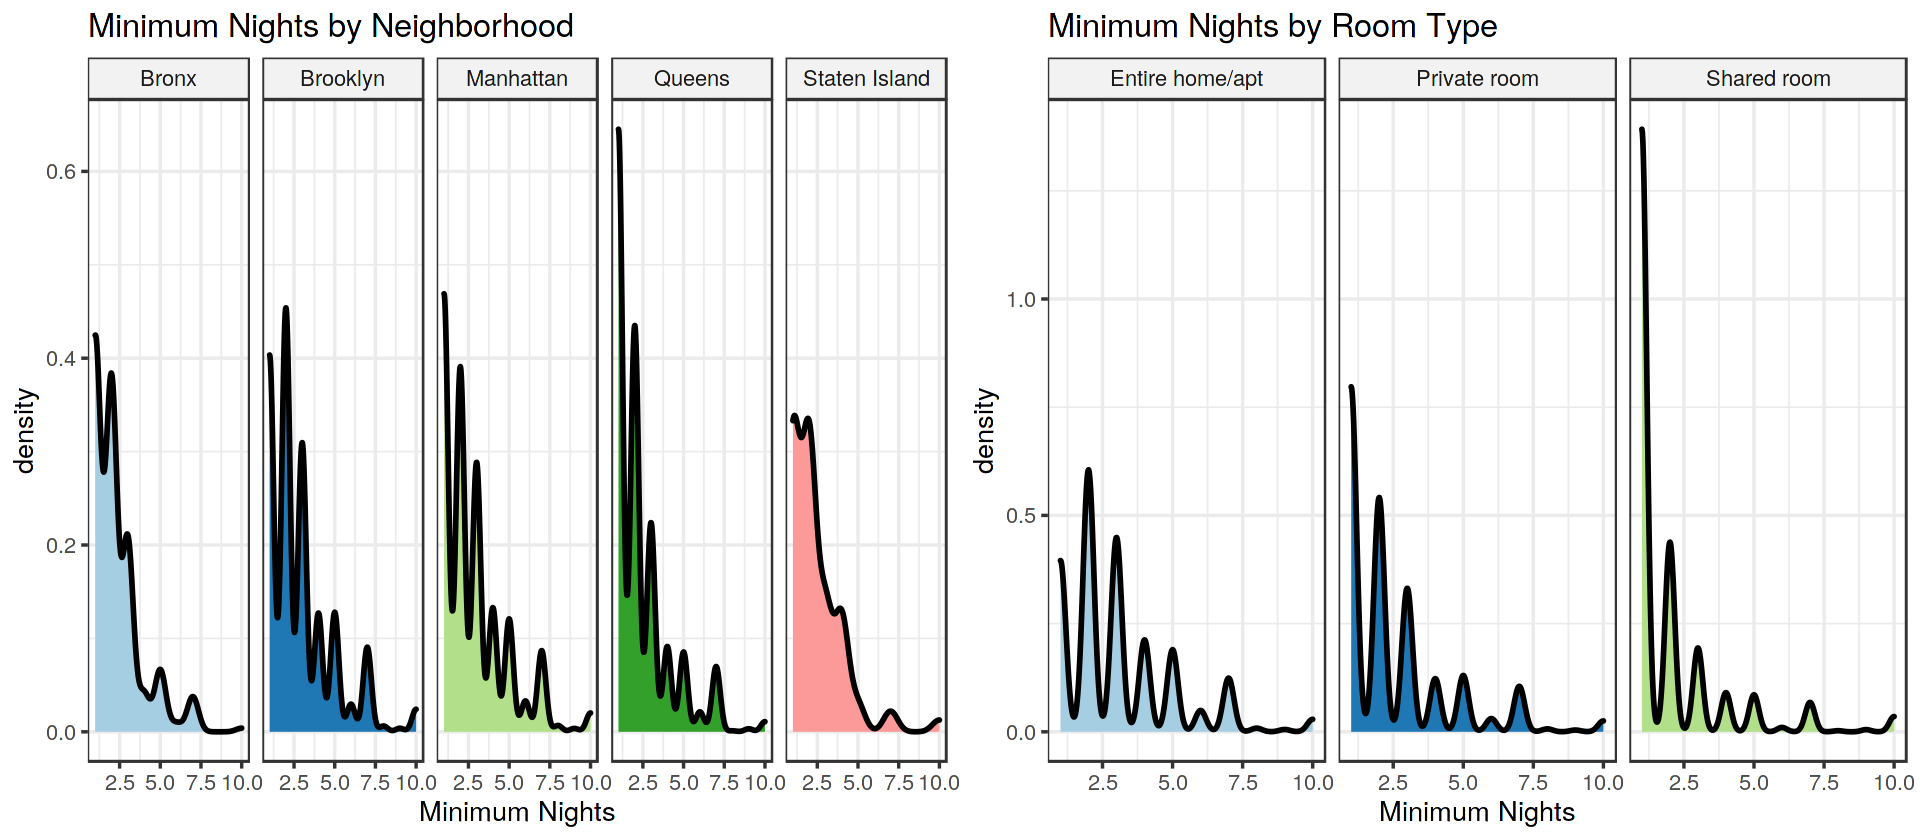

In [28]:
# Minimum Nights by neighborhood
a = ggplot(df2, aes(minimum_nights, fill = neighbourhood_group)) + 
  geom_density(show.legend = F, col = "black", lwd = 1.2) + 
  scale_fill_manual(values=pal) + theme_bw(base_size = 16)  +
  labs(title = "Minimum Nights by Neighborhood", x = "Minimum Nights") +
  facet_grid(~neighbourhood_group) +
  theme(strip.background = element_rect(fill="grey95"))

# Minimum Nights by room type
b= ggplot(df2, aes(minimum_nights, fill = room_type)) + 
  geom_density(show.legend = F, lwd = 1.2, col = "black") + facet_grid(~room_type) +
  scale_fill_manual(values=pal) + theme_bw(base_size = 16)  +
  labs(title = "Minimum Nights by Room Type", x = "Minimum Nights") +
  theme(strip.background = element_rect(fill="grey95"))

options(repr.plot.width=16, repr.plot.height=7)
plot_grid(a,b, ncol = 2, nrow = 1)


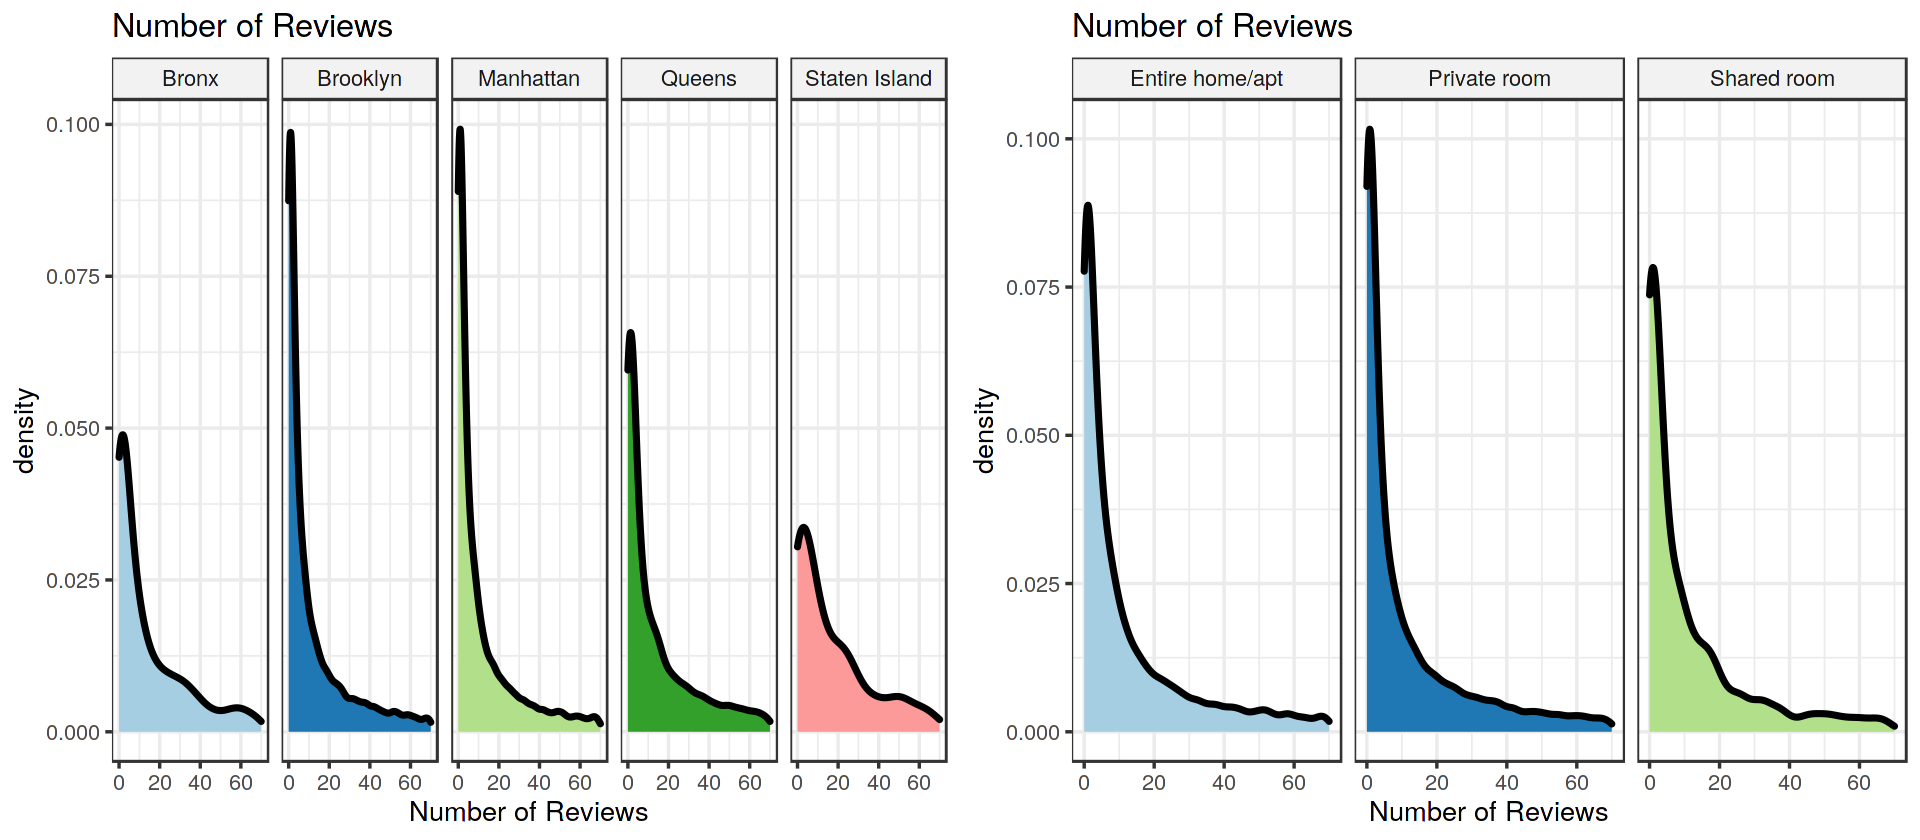

In [29]:
a = ggplot(df2, aes(number_of_reviews, fill = neighbourhood_group)) + 
  geom_density(show.legend = F, lwd = 1.5, col = "black") + 
  scale_fill_manual(values=pal) + theme_bw(base_size = 16)  +
  labs(title = "Number of Reviews", x = "Number of Reviews") +
  facet_grid(~neighbourhood_group) +
  theme(strip.background = element_rect(fill="grey95"))

# price by room type
b = ggplot(df2, aes(number_of_reviews, fill = room_type)) + 
  geom_density(show.legend = F, lwd = 1.5, col = "black") + facet_grid(~room_type) +
  scale_fill_manual(values=pal) + theme_bw(base_size = 16)  +
  labs(title = "Number of Reviews", x = "Number of Reviews") +
  theme(strip.background = element_rect(fill="grey95"))

plot_grid(a,b, ncol = 2, nrow = 1)

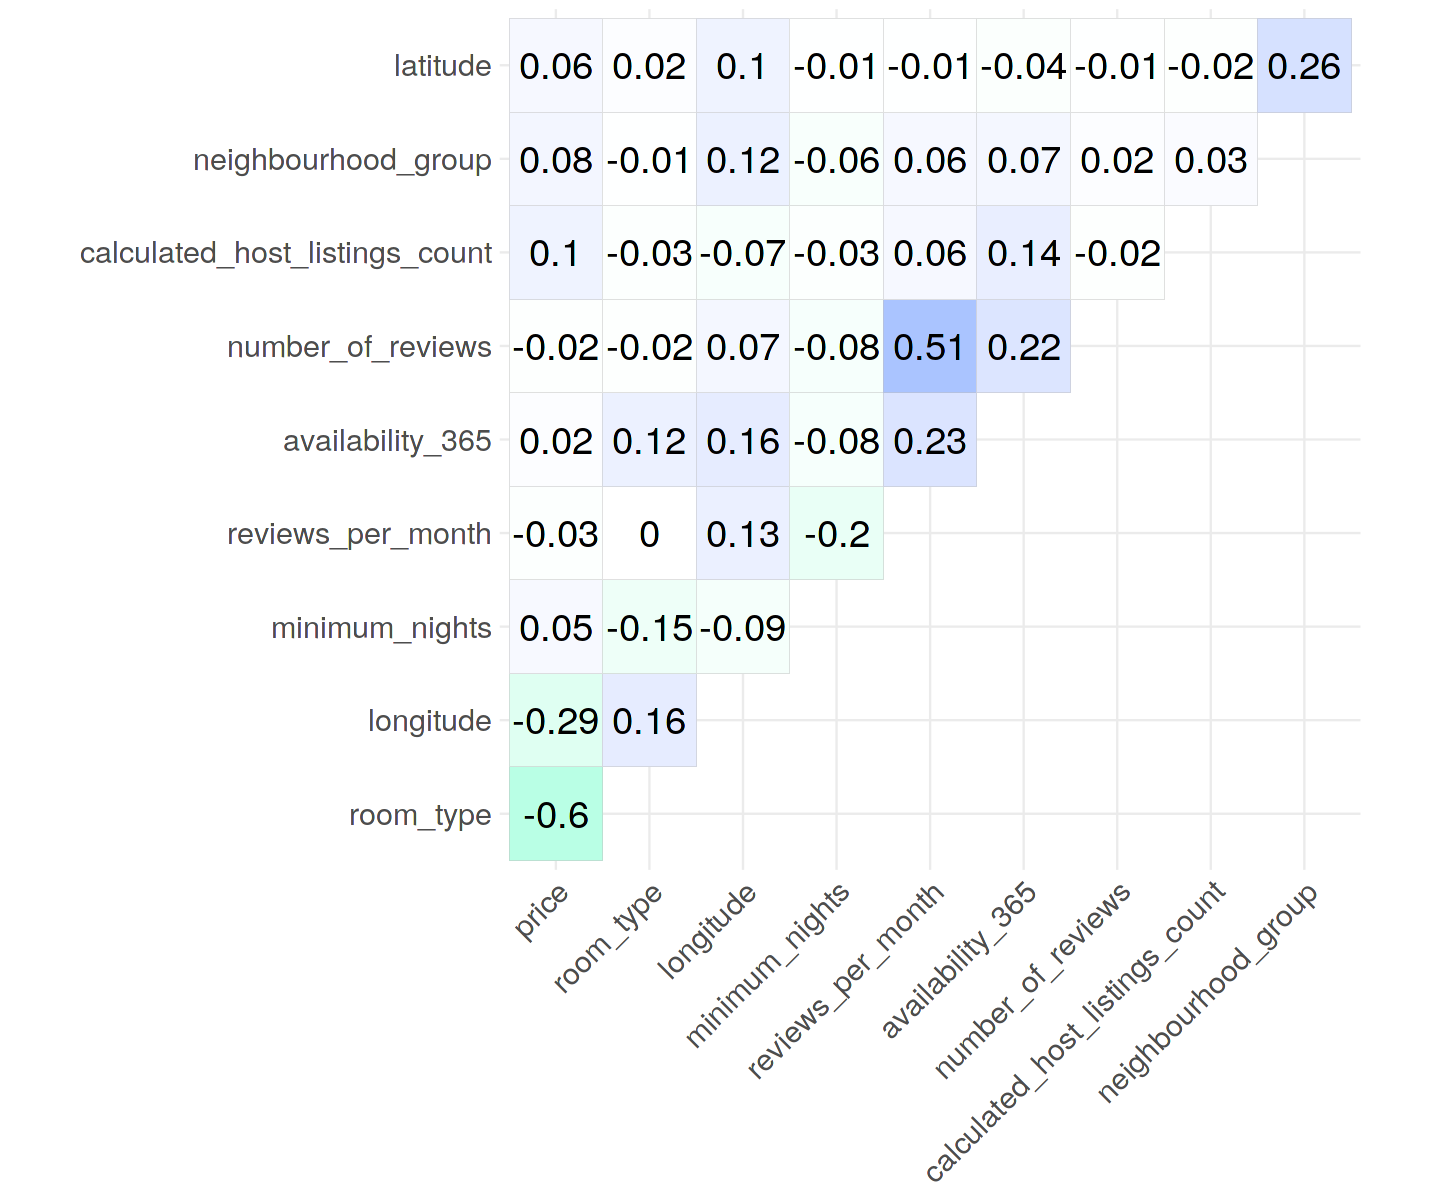

In [42]:
#--------------------------------------#
######         Correlations       ######
#--------------------------------------#

c <- df2
#df %>% select_if(is.factor) %>% names()
cols = c("neighbourhood_group", "room_type" )
c[, cols] <- c %>% select_if(is.factor) %>% lapply(as.numeric)
# create correlation matrix
cor <- cor(c)
#names(c) # gather all the column names
cols <- c("price",
          "neighbourhood_group",           
          "latitude", 
          "longitude",                     
          "room_type",
          "minimum_nights",                
          "number_of_reviews", 
          "reviews_per_month",             
          "calculated_host_listings_count",
          "availability_365" )        
# stack the correlations
cor <- as_tibble(reshape2::melt(cor, id = cols))
# rename the columns appropriately
colnames(cor) <- c("Target", "Variable", "Correlation")

#---------------------------#
#####    Corr Plot     ######
#---------------------------#

par(mfrow = c(1,1))
options(repr.plot.width=12, repr.plot.height=10)
ggcorrplot(mat.sort(cor(c)), lab = TRUE, 
               colors = c("aquamarine", "white", "dodgerblue"),
               show.legend = F, outline.color = "gray", type = "upper",
               tl.cex = 18, lab_size = 8, sig.level = .2) +
  labs(fill = "Correlation")


In [38]:
#--------------------------------------#
######      Multicollinearity     ######
#--------------------------------------#

# Step 1) Dropping response variable (Y)
c %>% select(everything(), - price)
m <- subset(c, select = -price)
mc <- cor(m)
# Checking Variables that are highly correlated
highlyCorrelated = findCorrelation(mc, cutoff=0.7)
highlyCorCol = colnames(m)[highlyCorrelated]
highlyCorCol 

neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,40.64749,-73.97237,2,1,9,0.21,6,365
3,40.75362,-73.98377,1,1,45,0.38,2,355
3,40.80902,-73.94190,2,3,0,0.00,1,365
3,40.79851,-73.94399,1,10,9,0.10,1,0
3,40.80316,-73.96545,1,5,53,0.43,1,6
2,40.67592,-73.94694,1,3,53,4.44,1,21
3,40.79685,-73.94872,1,7,0,0.00,2,249
2,40.71842,-73.95718,1,3,9,0.07,1,0
2,40.67989,-73.97798,2,1,39,0.37,6,364


character(0)

In [39]:
#--------------------------------------------------#
#######      Check the Results using VIF      ######
#--------------------------------------------------#

# Choose a VIF cutoff under which a variable is retained 
# vif > 10  = multi-collinearity (Zuur et al. 2010)
#can also reject predictors with vf 5-10

# model 1
fit1 <- lm(price ~., data = c); #summary(fit1)
vif(fit1) 

neighbourhood_group                       latitude 
                      1.093851                       1.083564 
                     longitude                      room_type 
                      1.087609                       1.065210 
                minimum_nights              number_of_reviews 
                      1.073376                       1.378366 
             reviews_per_month calculated_host_listings_count 
                      1.434202                       1.039998 
              availability_365 
                      1.141387

In [69]:
###############################################################
#-------------------------------------------------------------#
#####           AirBnB NYC - Machine Learning            ######
#####         Cross Validation Model Comparison          ######
#-------------------------------------------------------------#
###############################################################


# prepare training scheme
control <- trainControl(method="repeatedcv", number=10, repeats=10,
                        selectionFunction = "oneSE")

# sample the data for faster run time
s = sample_n(s, size = 1000, replace = TRUE)

In [41]:
#-----------------------------------#
######      Linear model        #####
#-----------------------------------#

m_lm <- train(price~., data=s, method="lm", trControl=control);

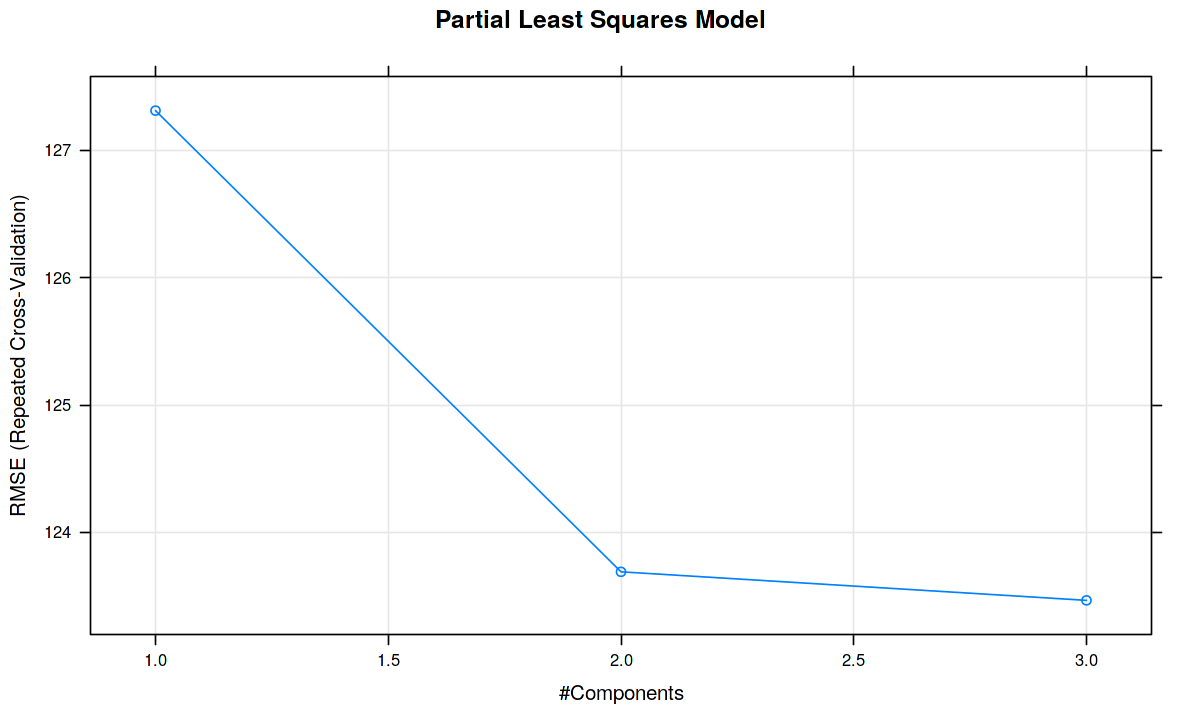

In [48]:
#------------------------------------------------#
######        Partial Least Squares         ######
#------------------------------------------------#

m_pls <- train(price ~., data = s,
               method = 'pls', 
               preProcess = c("center", "scale"),
               trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

options(repr.plot.width=10, repr.plot.height=6)
plot(m_pls, main = "Partial Least Squares Model");
#m_pls$bestTune;


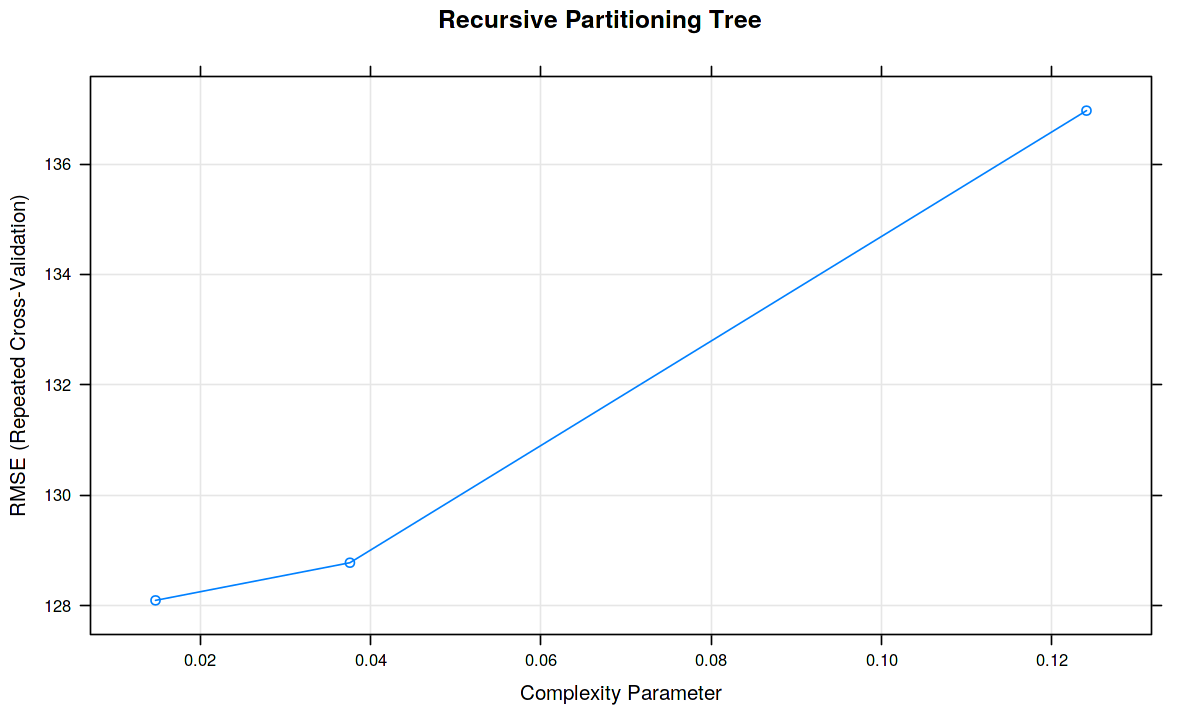

In [49]:
#-----------------------------------------------------------#
####    Recursive Partitioning and Regression Trees    ######
#-----------------------------------------------------------#

# library(rpart)
set.seed(123) 
m_rpart <- train(price ~., data = s, method = 'rpart', 
                 #tunelength = 30, 
                 trControl=control);
# m_rpart$results

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_rpart, main = "Recursive Partitioning Tree");
#m_rpart$bestTune;

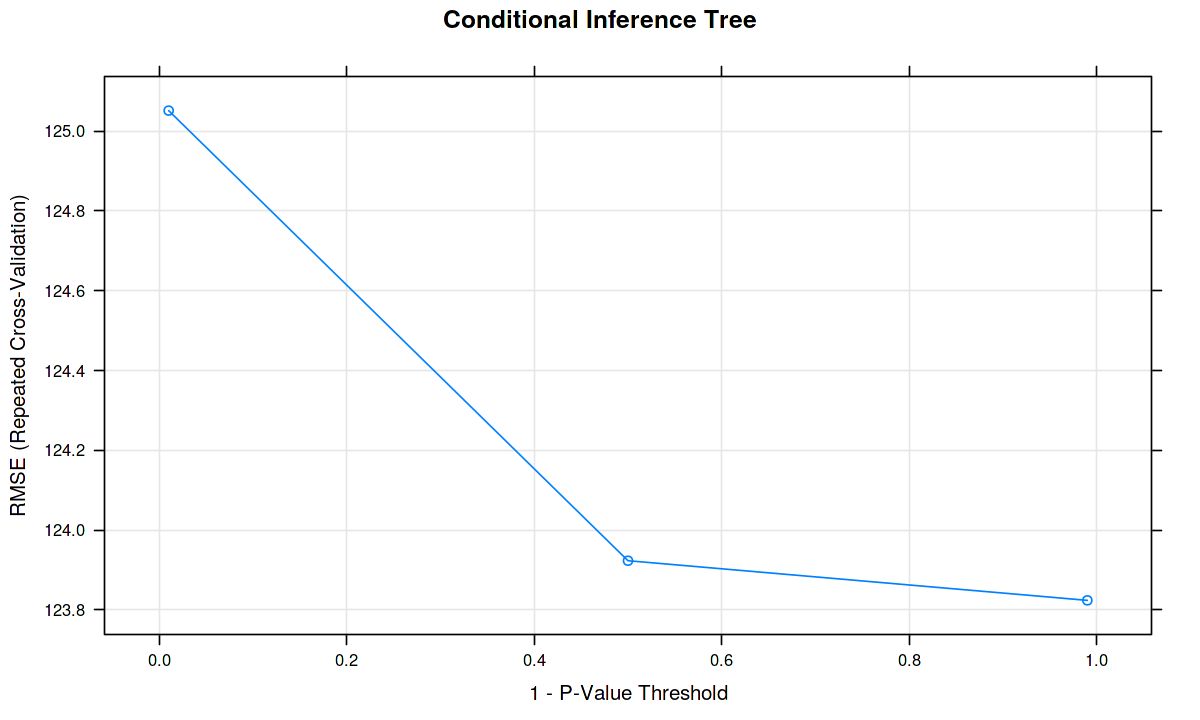

In [50]:
#------------------------------------------#
####    Conditional Inference Tree    ######
#------------------------------------------#

set.seed(123) 
m_ctree <- train(price ~., data = s,
                 method = 'ctree', 
                 #tunelength = 10,
                 trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_ctree, main = "Conditional Inference Tree");
# densityplot(m_ctree, pch = "|")
#m_ctree$bestTune;

In [80]:
#---------------------------------------------------#
####    Conditional Inference Random Forest    ######
#---------------------------------------------------#

set.seed(123)
m_cforest <- train(price ~., data = s,
                 method = 'cforest',
                 #tunelength = 10,
                 trControl=control);

In [52]:
#-----------------------------#
####     Bagged CART     ######
#-----------------------------#

library(ipred)
library(e1071)

set.seed(123) 
m_treebag <- train(price~., data=s, method = 'treebag', 
                   trControl=control);
# no tuning parameters



In [82]:
#----------------------------------#
####        Random Forest     ######
#----------------------------------#

library(randomForest)

set.seed(123) 
m_randomForest <- train(price~., data=s, method = 'rf', 
                        tunelength = 10,
                        ntrees = 150,
                        importance = TRUE,
                        trControl=control);



In [55]:
#-------------------------------------------------#
#######      Generalized Linear Models       ######
#-------------------------------------------------#


m_glm <- train(price~., data=s, method="glm", 
               trControl=control);


In [84]:
#-------------------------------------------------#
#######    Stochastic Gradient Boosting      ######
#-------------------------------------------------#

library(gbm)

# option to generate parameters or use caret to cross validate
gbmGrid <- expand.grid(n.trees = seq(100, 1000, by = 50),
                       interaction.depth = seq(1,9, by = 2),
                       shrinkage = c(0.01, 0.1),
                       n.minobsinnode = 10)

m_gbm <- train(price~., data=s, method="gbm", 
               tuneGrid = gbmGrid,
               trControl=control, 
               verbose=FALSE);


In [58]:
#---------------------------#
####   Cubist model    ######
#---------------------------#

library(Cubist)

cubistGrid = expand.grid(.committees = c(1,5,10,50,75,100),
                         .neighbors = c(0,1,3,5,7,9))

set.seed(123) 
m_cubist <- train(price ~., data = s,
                  method = 'cubist', 
                  tuneGrid = cubistGrid,
                  trControl=control);

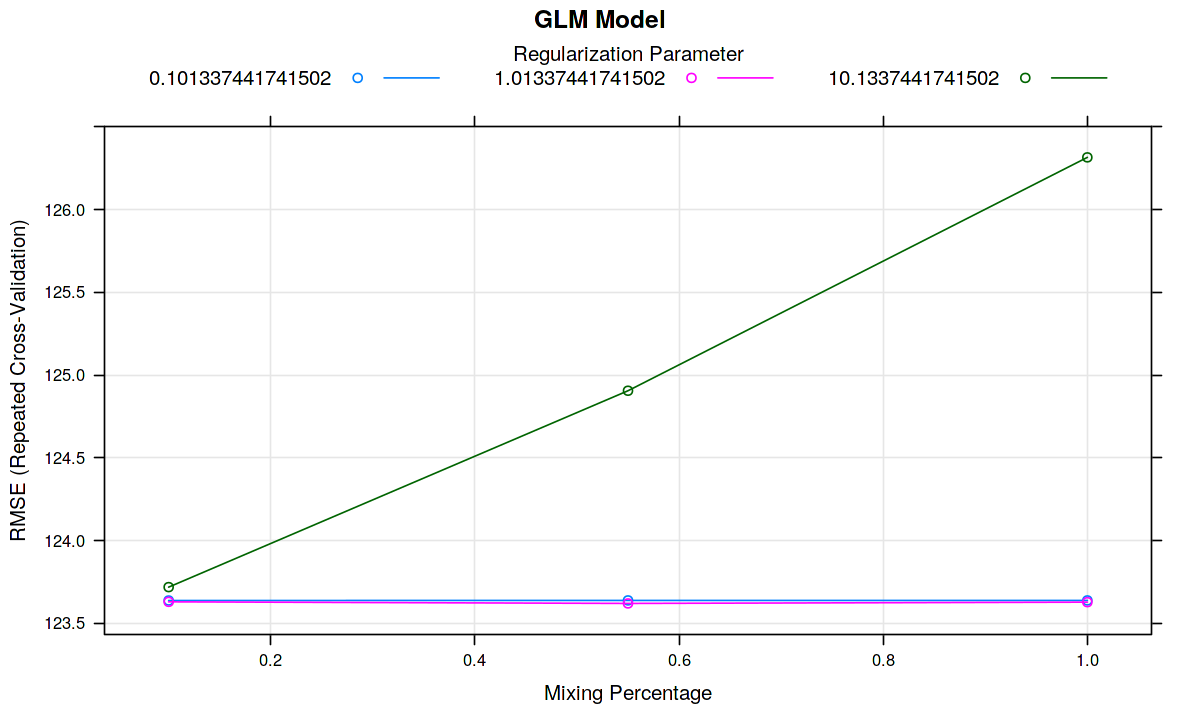

In [62]:
#----------------------------------------------------------------------#
####   generalized linear model via penalized maximum likelihood    ####
#----------------------------------------------------------------------#

library(glmnet)

set.seed(123) 
m_glmnet <- train(price ~., data = s,
                  method = 'glmnet', trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_glmnet, main = "GLM Model");

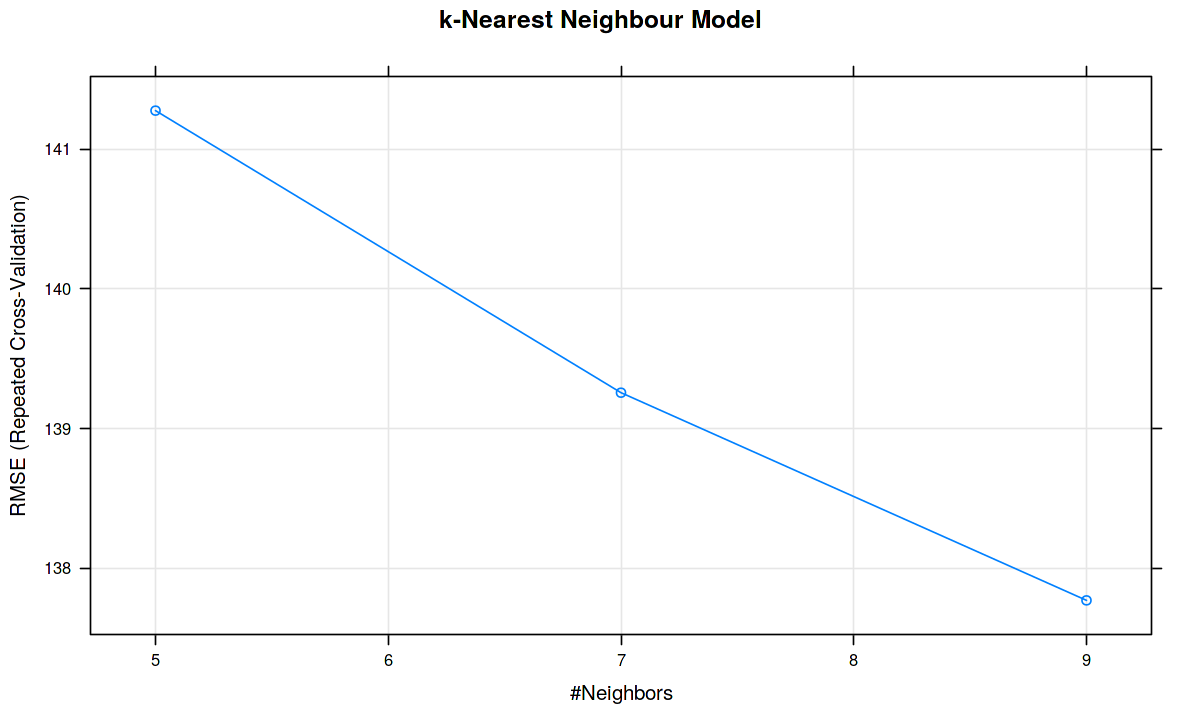

In [63]:
#--------------------------------#
####   k-Nearest Neighbour    ####
#--------------------------------#

set.seed(123) 
m_knn <- train(price ~., data = s,
               method = 'knn', trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_knn, main = "k-Nearest Neighbour Model");

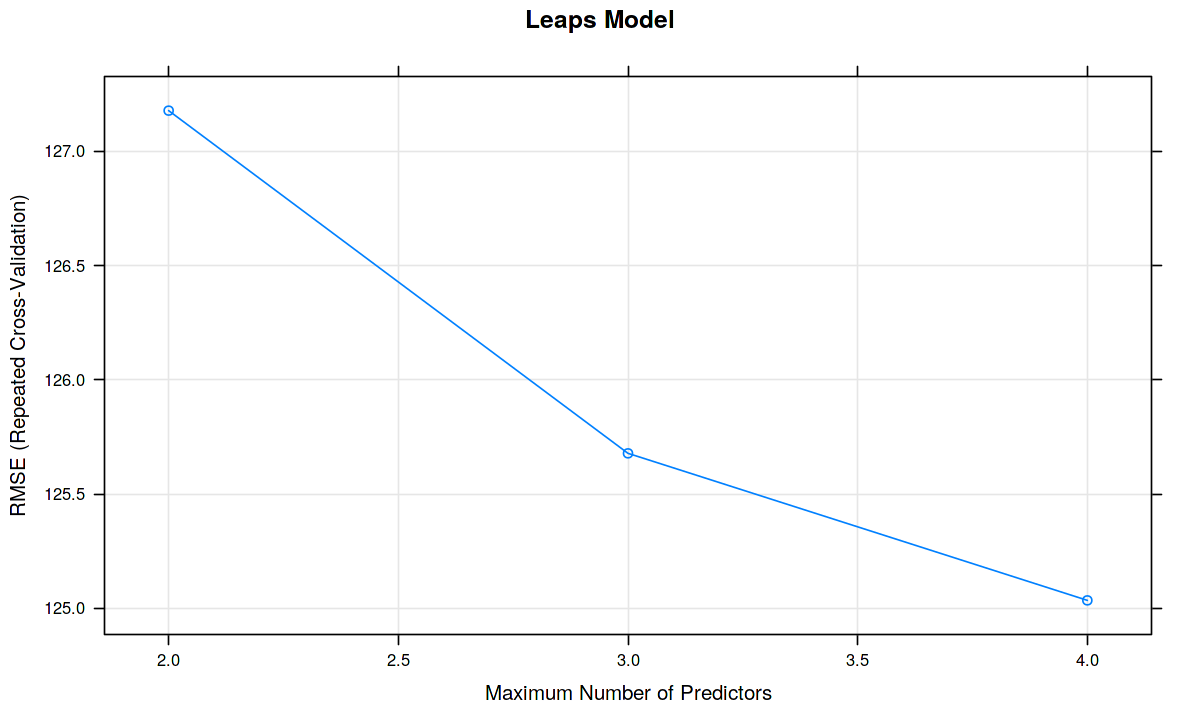

In [65]:
#-----------------------------------------------------#
####  Linear Regression with Stepwise Selection    ####
#-----------------------------------------------------#

library(leaps)
set.seed(123) 
m_leaps <- train(price ~., data = s,
                 method = 'leapSeq', trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_leaps, main = "Leaps Model");

In [67]:
#----------------------------------------------------#
####   Multivariate Adaptive Regression Spline    ####
#----------------------------------------------------#

library(earth)

set.seed(123) 
m_earth <- train(price ~., data = s,
                 method = 'earth', trControl=control,
                 tuneGrid = expand.grid(.degree = 1,
                                        .nprune = 2:25))


In [68]:
#-----------------------------------------------------------#
####   Bagged Multivariate Adaptive Regression Spline    ####
#-----------------------------------------------------------#

set.seed(123) 
m_bagEarth <- train(price ~., data = s,
                    method = 'bagEarth', trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_bagEarth, main = "Bagged Earth Model");

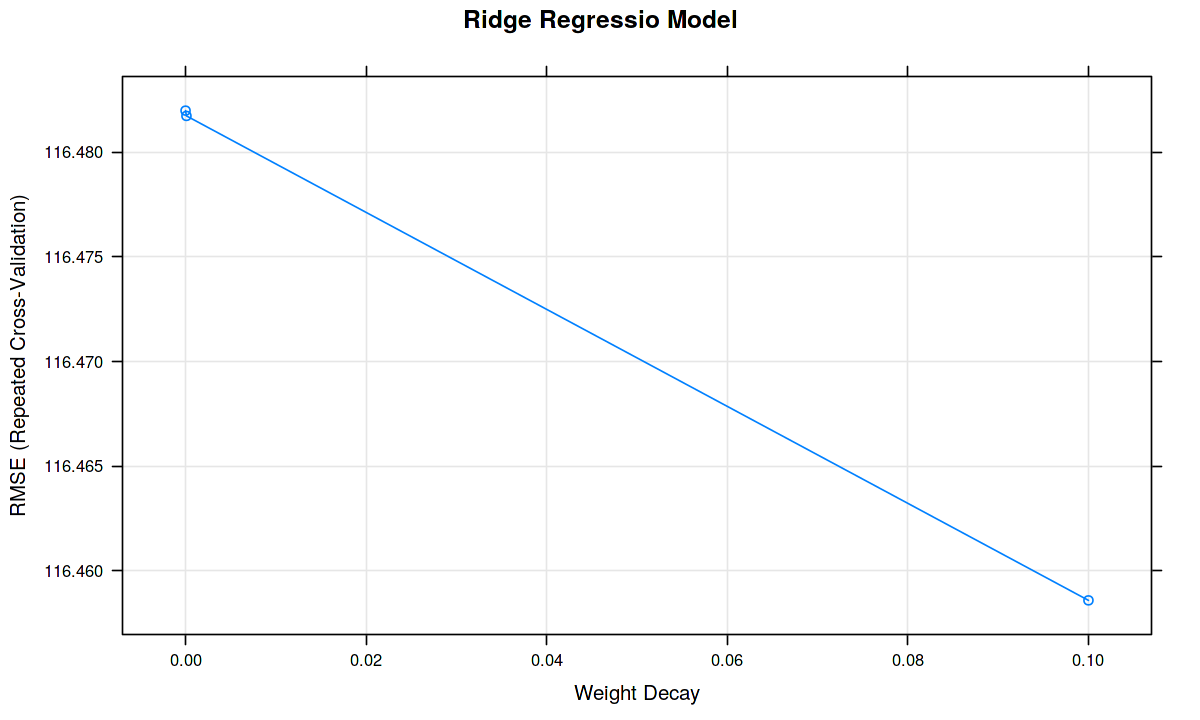

In [71]:
#------------------------------------------#
#######        Ridge Regression       ######
#------------------------------------------#

library(elasticnet)
set.seed(123) # Ridge Regression with Variable Selection
m_ridge <- train(price~., data=s, method = 'ridge',
                 trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_ridge, main = "Ridge Regressio Model");


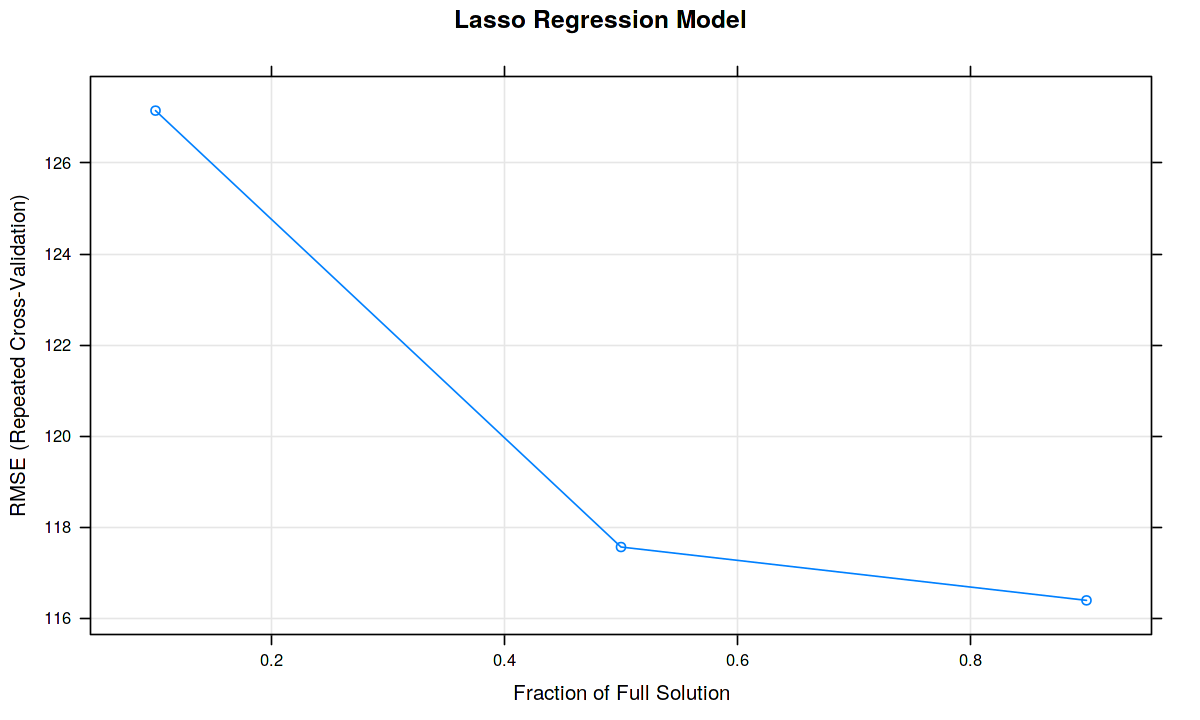

In [73]:
#------------------------------------------#
#######        Lasso Regression       ######
#------------------------------------------#

library(elasticnet)
set.seed(123) # Quantile Regression with LASSO penalty
m_lasso <- train(price ~., data=s, method = 'lasso', 
                 trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_lasso, main = "Lasso Regression Model");


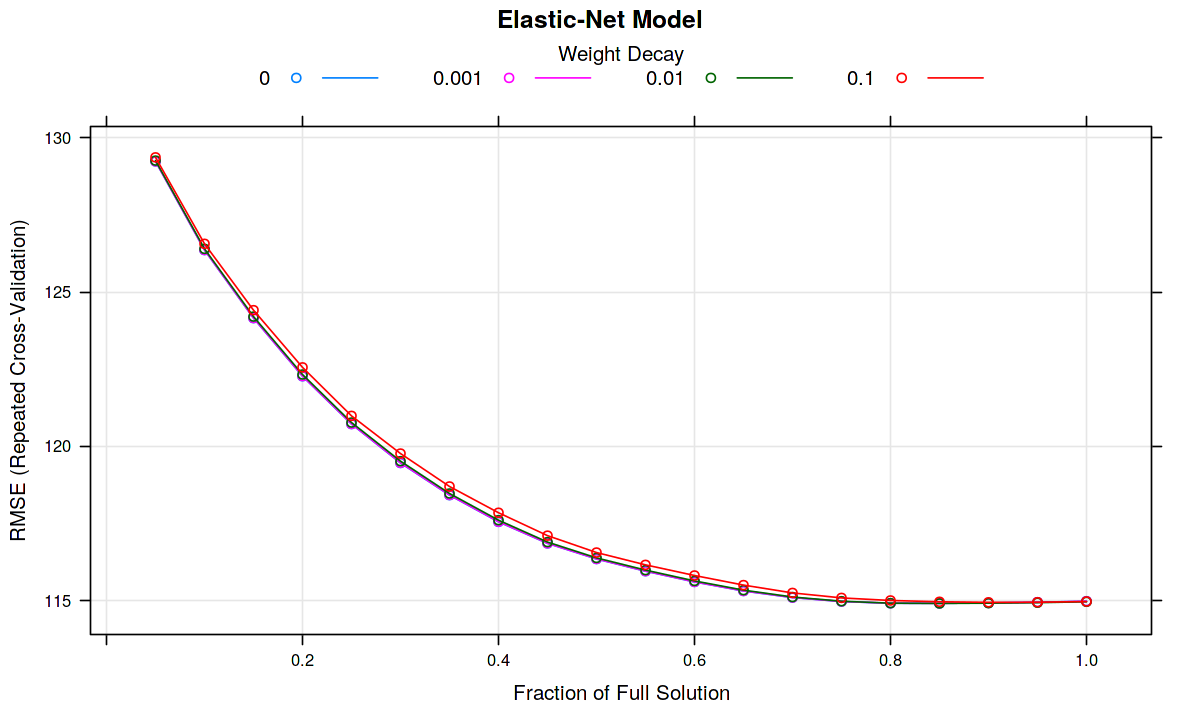

In [74]:
#----------------------------------------------------#
######    Elastic-Net for Sparse Estimation     ######
#----------------------------------------------------#

enetGrid <- expand.grid(.lambda = c(0, .001, .01, .1),
                        .fraction = seq(0.05, 1, length = 20))

m_enet <- train(price ~., data = s,
                method = 'enet', 
                preProcess = c("center", "scale"),
                tuneGrid = enetGrid,
                trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_enet, main = "Elastic-Net Model");

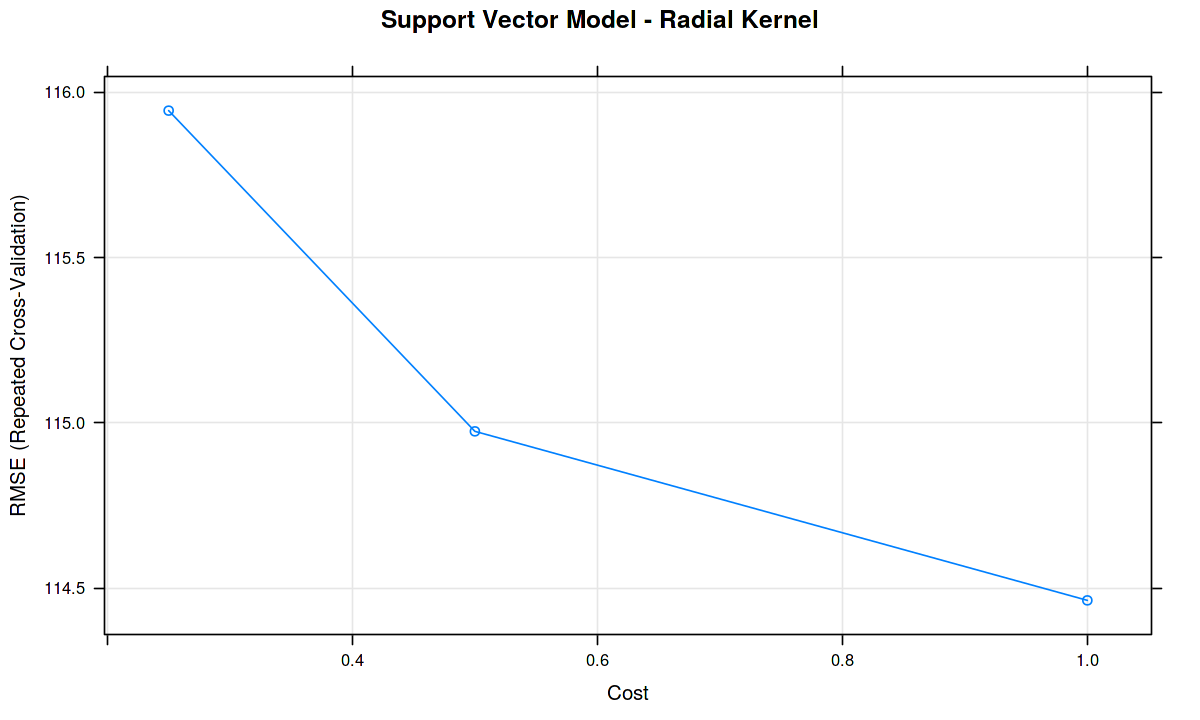

In [76]:
#-----------------------------------------------#
#######       Support Vector Machines      ######
#######   Radial Basis Function Kernel     ######
#-----------------------------------------------#

library(kernlab)

set.seed(123) # Support Vector Machines with Radial Basis Function Kernel
m_svmRadial <- train(price~., data=s, method="svmRadial", 
                     tunelength = 15,
                     preProcess = c("center", "scale"),
                     trControl=control);

######-----  Visualize the Cross Validation  ----- #####
#####-------- & best tuned model parameters  ----- #####

plot(m_svmRadial, main = "Support Vector Model - Radial Kernel");

In [78]:
#---------------------------------------------------------------#
#######      Support Vector Machines with Linear Kernel    ######
#---------------------------------------------------------------#

library(ipred)

set.seed(123) 
m_svmLinear <- train(price ~., data=s, method = 'svmLinear', 
                     trControl=control);

In [88]:
###############################################################
#-------------------------------------------------------------#
#####           Machine Learning  - AirBnB NYC           ######
#####     Final Model Testing & Accuracy Comparison      ######
#-------------------------------------------------------------#
###############################################################

library(vip)
library(xgboost)
library(mboost)
library(ranger) 
library(rpart)
library(party)
library(randomForest)
library(pls)
library(ipred)
library(elasticnet)
library(gbm)
library(Cubist)
library(glmnet)
library(leaps)
library(earth)
library(kernlab)
library(caTools)
library(mgcv)

In [90]:
#----------------------------------------------------#
####         Training & Testing Splits           #####
#----------------------------------------------------#

#---- run all (command + option + R) -----#

# sample the data for faster run time
s = sample_n(s, size = 1000, replace = TRUE)
trainIndex <- createDataPartition(s$price, p = .75, 
                                  list = FALSE, times = 1)
train = s[trainIndex, ]; #class(train)
test = s[-trainIndex, ]; #class(test)

#----------------------------------------------------#
####   Training & Testing Splits ( X & Y)        #####
#----------------------------------------------------#

x_train <- train[-1]; #class(x_train)
x_test <- test[-1]; #class(x_test)
y_train <- train$price; #class(y_train)
y_test <- test$price; #class(y_test)

#-------------------------------------------------------#
####   Training & Testing Splits ( X & Y Matrix)    #####
#-------------------------------------------------------#

train.X.m <- model.matrix(price ~ ., train)[,-1]; #class(train.X.m)
train.Y <- train$price; #class(train.Y)
test.X.m <- model.matrix(price ~ ., test)[,-1]; #class(test.X.m);
test.Y <- test$price; #class(test.Y)

In [91]:
#-------------------------------------------------#
#####     Linear Regression  - Math Model     #####
#-------------------------------------------------#

#noquote(names(train))
m.lm <- lm(price ~ 
             #neighbourhood_group + 
             #latitude +                      
             #longitude + 
             room_type +                     
             minimum_nights + 
             number_of_reviews +             
             #reviews_per_month  +  
             #calculated_host_listings_count +
             availability_365,
           data = train);
summary(m.lm)



Call:
lm(formula = price ~ room_type + minimum_nights + number_of_reviews + 
    availability_365, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-145.54  -49.23  -17.65   12.51  917.93 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            192.31889    6.72789  28.585  < 2e-16 ***
room_typePrivate room -109.55682    8.25789 -13.267  < 2e-16 ***
room_typeShared room  -128.89198   24.72634  -5.213 2.41e-07 ***
minimum_nights          -0.69049    0.22730  -3.038  0.00247 ** 
number_of_reviews       -0.36484    0.12220  -2.986  0.00292 ** 
availability_365         0.14177    0.03209   4.418 1.14e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 110.3 on 745 degrees of freedom
Multiple R-squared:  0.2199,	Adjusted R-squared:  0.2147 
F-statistic:    42 on 5 and 745 DF,  p-value: < 2.2e-16


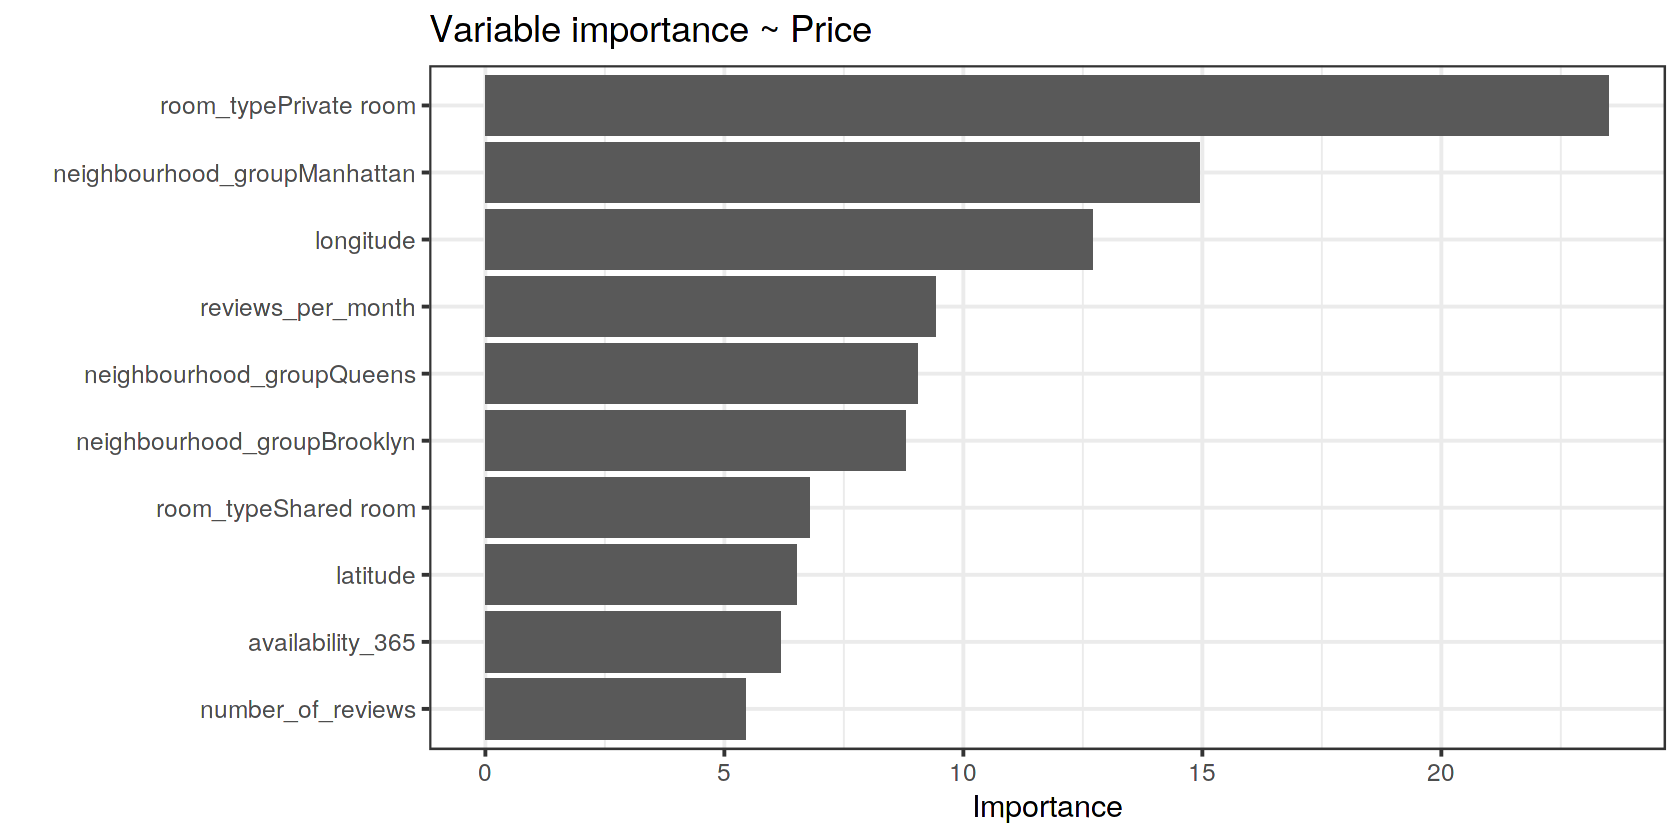

In [96]:
#-------------------------------------------------------#
######   Partial Least-Squares Regression (PLS)    ######
#-------------------------------------------------------#

# center and scale the data
m.mvr <- mvr(price ~., data = train,
             scale = TRUE, center = TRUE, ncomp = 3);


### ----- Variable Importance  ----#### 

options(repr.plot.width=14, repr.plot.height=7)
vip::vip(m.mvr) + theme_bw(base_size = 18) +
  labs(title = "Variable importance ~ Price")


In [97]:
#----------------------------------------------------#
####      Boosted Generalized Linear Model      ######
#----------------------------------------------------#

m.blackboost <- blackboost(price ~., data = train, 
                           family = Gaussian())

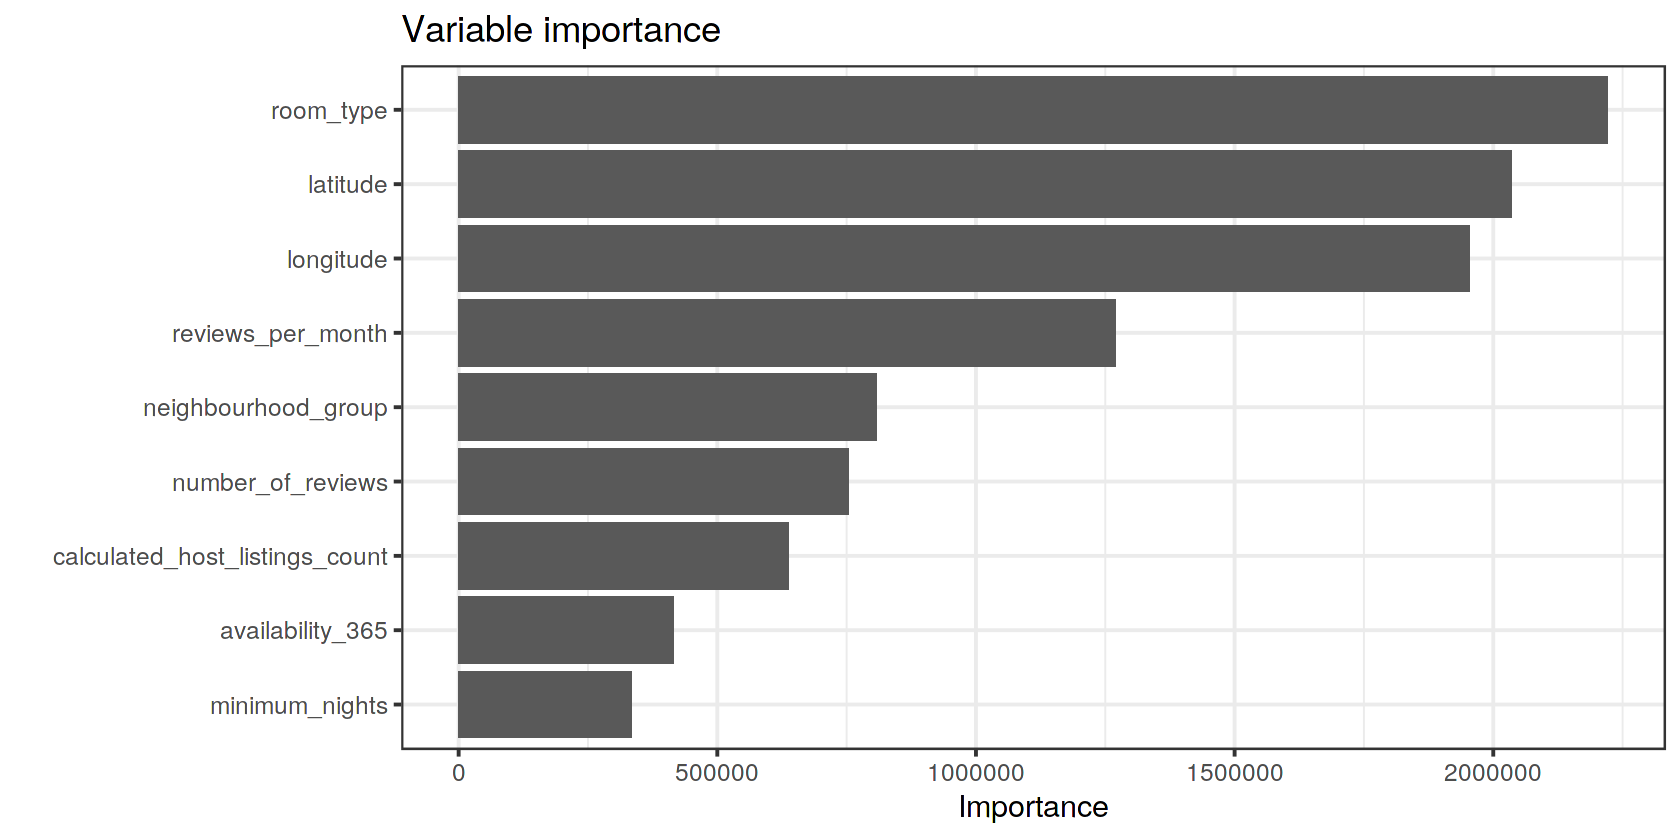

In [100]:
#-----------------------------------------------------------#
####    Recursive Partitioning and Regression Trees    ######
#-----------------------------------------------------------#

m.rpart = rpart(formula = price ~ .,
                data = train, method = "anova",
                control = rpart.control(cp = 0.02528936))

#--------------------------------------------------#
######   Visualize the Varaible Importance    ######
#--------------------------------------------------#

vip::vip(m.rpart) + theme_bw(base_size = 18) +
  labs(title = "Variable importance")
             

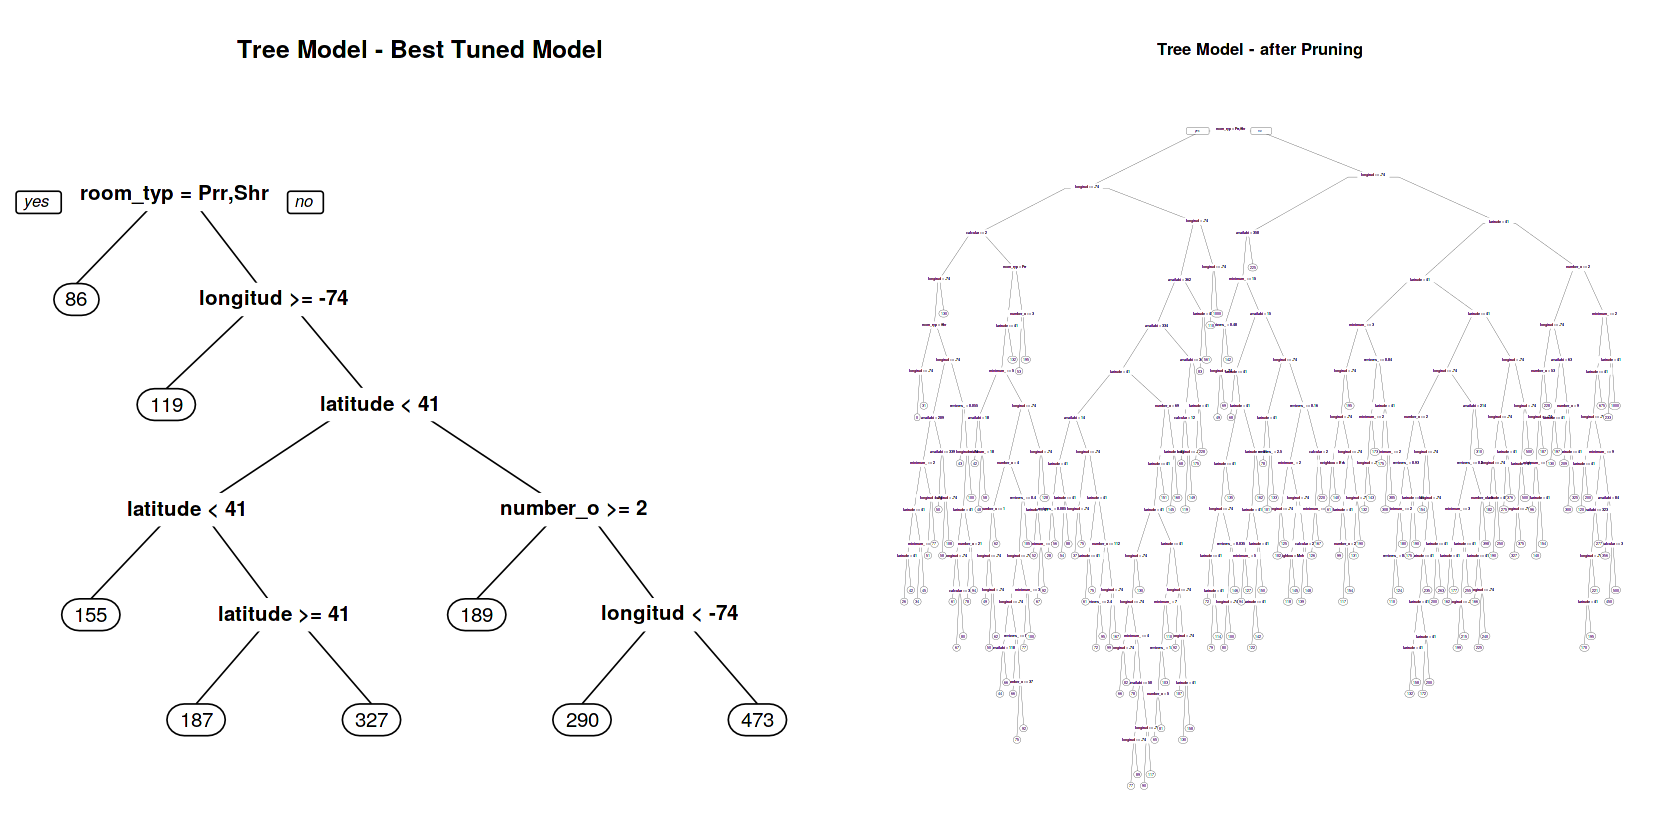

In [101]:
#-------------------------------------------------#
#####        Grow and prune the trees        ######
#-------------------------------------------------#

m_tree = rpart(formula = price ~ .,
                  data = train, method = "anova",
                  control =rpart.control(minsplit = 5, cp=0.0));
m_ocp = m_tree$cptable[which.min(m_tree$cptable[,"xerror"]), "CP"]

#------------------------------------------#
####         Pruned Tree Models         ####
#------------------------------------------#

m.rpart.prn <- prune(m_tree, m_ocp);

#---------------------------------------------------------#
####     Visualize models before and after pruning    #####
#---------------------------------------------------------#

options(repr.plot.width=14, repr.plot.height=7)
par(mfrow = c(1,2))
prp(m.rpart, main = "Tree Model - Best Tuned Model");
prp(m.rpart.prn, main = "Tree Model - after Pruning");
par(mfrow = c(1,1))

In [104]:
#------------------------------------------#
####    Conditional Inference Tree    ######
#------------------------------------------#

mtry = round(ncol(df)/3,0)

m.ctree <- ctree(price~., data = s, 
                 control = ctree_control(teststat = c("quad", "max"), 
                                         testtype = c("Bonferroni", "MonteCarlo", 
                                                      "Univariate", "Teststatistic"), 
                                         mincriterion = 0.01, minsplit = 20, minbucket = 7, 
                                         mtry = mtry, savesplitstats = TRUE, 
                                         maxdepth = 0, remove_weights = FALSE))


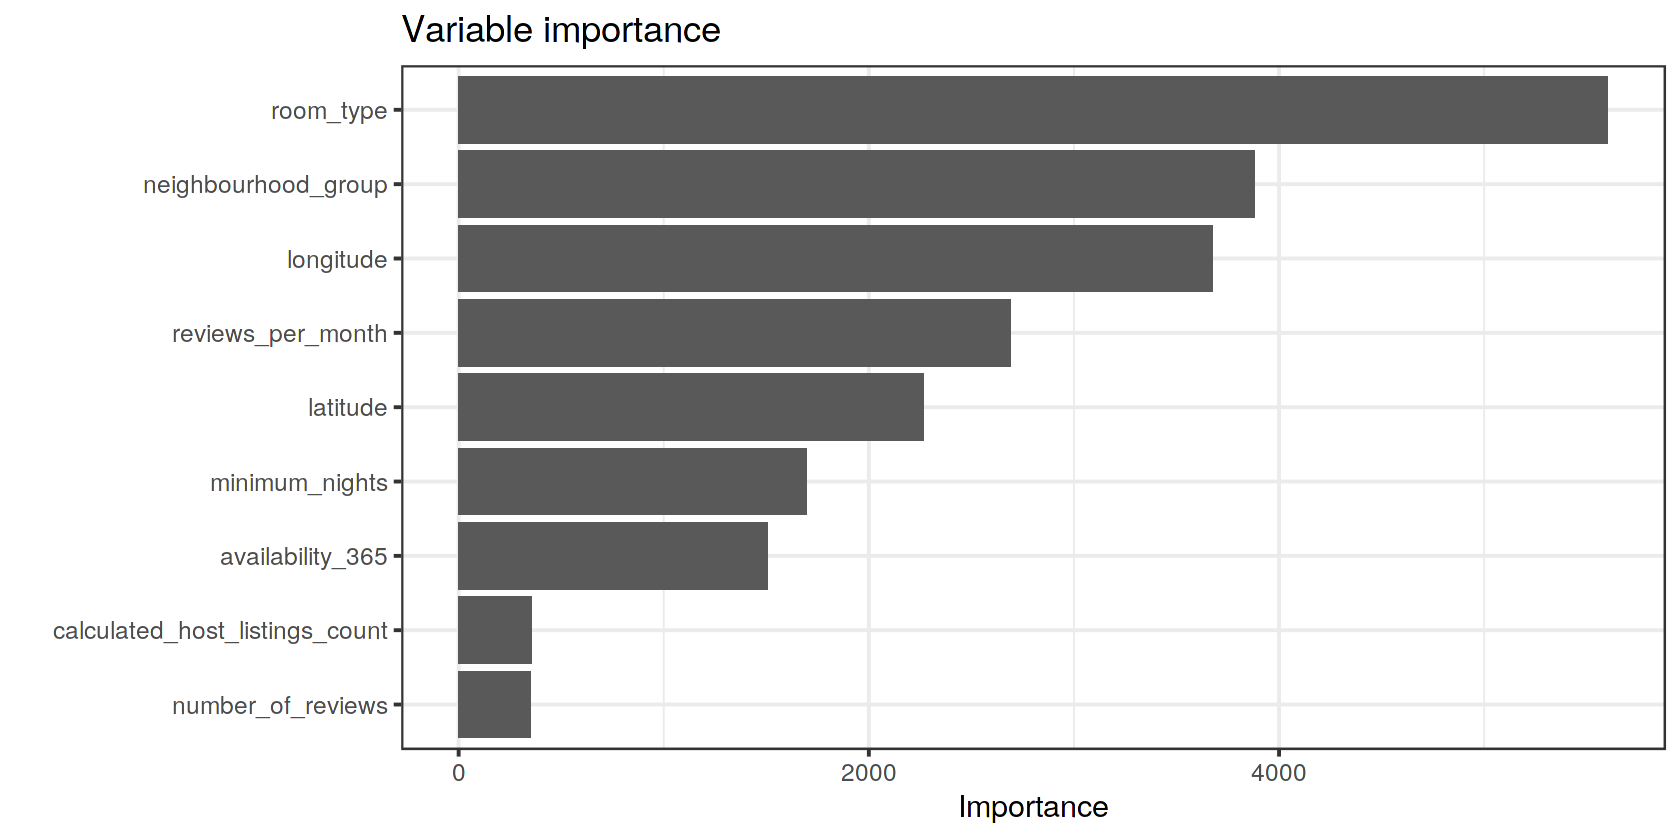

In [106]:
#---------------------------------------------------#
####    Conditional Inference Random Forest    ######
#---------------------------------------------------#

forest.controls = cforest_control(mincriterion = 0.5,
                          ntree = 500, mtry = 13)

m.cforest = cforest(price ~ 
          neighbourhood_group +
          latitude +                    
          longitude +
          room_type +                    
          minimum_nights +
          number_of_reviews +            
          reviews_per_month +
          calculated_host_listings_count +
          availability_365,
        data=train,
        control = forest.controls)

#--------------------------------------------------#
######   Visualize the Varaible Importance    ######
#--------------------------------------------------#

vip::vip(m.cforest) + theme_bw(base_size = 18) +
  labs(title = "Variable importance");

In [107]:
#-----------------------------#
####     Bagged CART     ######
#-----------------------------#

set.seed(123) 
m.treebag <- bagging(price~., data=train);

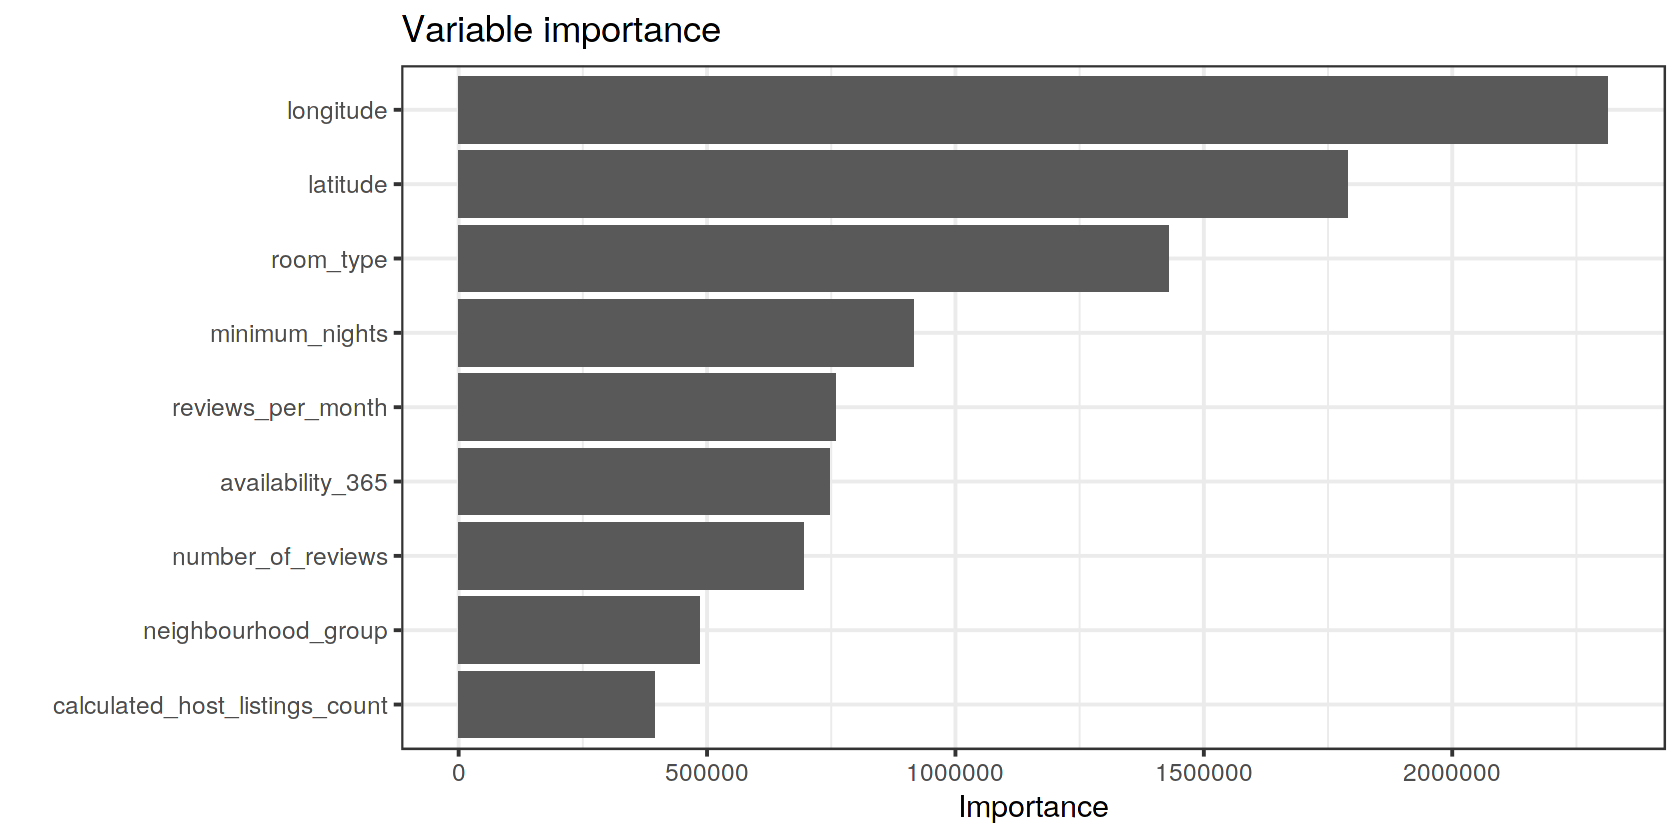

In [109]:
#----------------------------------#
####        Random Forest     ######
#----------------------------------#

set.seed(123) 
m.randomForest <- randomForest(price ~., data = train,
                        ntrees = 500,
                        mtry = 2);

#--------------------------------------------------#
######   Visualize the Varaible Importance    ######
#--------------------------------------------------#

vip::vip(m.randomForest) + theme_bw(base_size = 18) +
  labs(title = "Variable importance");

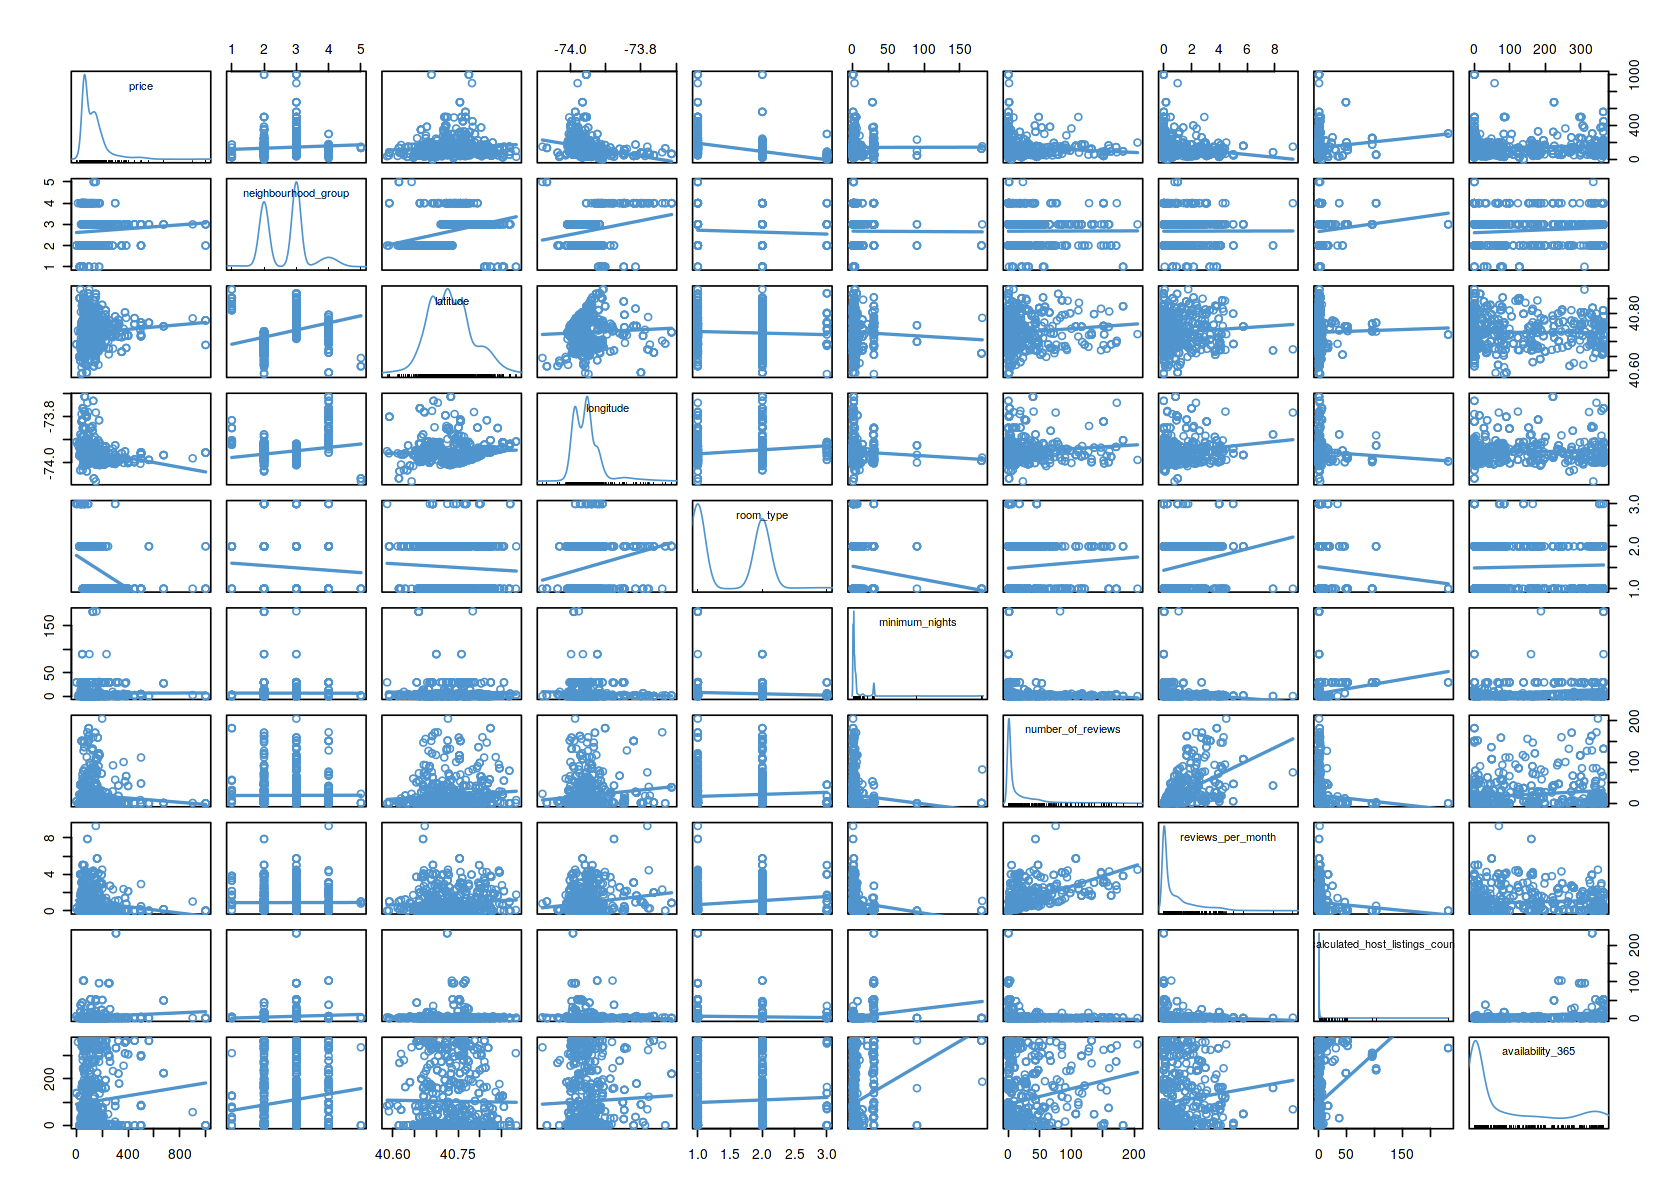

In [111]:
#---------------------------------------------------------#
#####     Generalized Additive Model using Splines    #####
#---------------------------------------------------------#

# working with parametric & nonparametric data to incorporate linear & 
# nonlinear forms of predictors & blend properties of generalized linear 
# models with additive models.

# the data includes a mix of parametric and nonparemtric data
options(repr.plot.width=14, repr.plot.height=10)
scatterplotMatrix(s, smooth=FALSE, col = "steelblue3");

In [112]:
#-----------------------------------------------------#
#####      Fitting Generalized Additive Models    #####
#-----------------------------------------------------#

m.gam <- gam(price ~                        
                #neighbourhood_group +          
                #latitude +
                longitude +                    
                room_type +
                minimum_nights +               
                number_of_reviews +
                #reviews_per_month +             
                #calculated_host_listings_count + 
                availability_365,
                data = train); 
summary(m.gam);


Family: gaussian 
Link function: identity 

Formula:
price ~ longitude + room_type + minimum_nights + number_of_reviews + 
    availability_365

Parametric coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -3.377e+04  6.283e+03  -5.375 1.03e-07 ***
longitude             -4.591e+02  8.494e+01  -5.405 8.72e-08 ***
room_typePrivate room -1.004e+02  8.281e+00 -12.124  < 2e-16 ***
room_typeShared room  -1.180e+02  2.435e+01  -4.847 1.53e-06 ***
minimum_nights        -7.613e-01  2.235e-01  -3.406 0.000695 ***
number_of_reviews     -2.839e-01  1.209e-01  -2.348 0.019114 *  
availability_365       1.512e-01  3.154e-02   4.793 1.99e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


R-sq.(adj) =  0.243   Deviance explained = 24.9%
GCV =  11830  Scale est. = 11720     n = 751

In [113]:
#----------------------------------------------------#
#####   nonparametric smoothing terms are       ######
#####   indicated by s for smoothing splines    ######
#----------------------------------------------------#

# select the statistically significant variables from the original model
# and fit an actual generalized additive model using cubic splines

m.gam.spline <- gam(price ~                        
                      #neighbourhood_group +          
                      #latitude +
                      s(longitude) +                    
                      room_type + # not applicable to factors
                      s(minimum_nights) +               
                      s(number_of_reviews) +
                      #reviews_per_month +             
                      #calculated_host_listings_count + 
                      s(availability_365),
                    data = train,); 

summary(m.gam.spline)


Family: gaussian 
Link function: identity 

Formula:
price ~ s(longitude) + room_type + s(minimum_nights) + s(number_of_reviews) + 
    s(availability_365)

Parametric coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            188.311      5.494  34.274  < 2e-16 ***
room_typePrivate room  -95.453      8.219 -11.613  < 2e-16 ***
room_typeShared room  -106.239     24.022  -4.423 1.12e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                       edf Ref.df      F  p-value    
s(longitude)         4.881  6.006  8.465 6.38e-09 ***
s(minimum_nights)    3.605  4.073  5.941 9.54e-05 ***
s(number_of_reviews) 5.687  6.790  5.012 1.94e-05 ***
s(availability_365)  1.000  1.000 23.147 1.81e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.292   Deviance explained = 30.8%
GCV =  11240  Scale est. = 10968     n = 751

In [115]:
#----------------------------------------------#
#####   Compare GAM to GAM with splines    #####
#----------------------------------------------#

# the splines improve model accuracy
m.gam[["aic"]]; m.gam.spline[["aic"]];
sum(m.gam[["residuals"]]^2); sum(m.gam.spline[["residuals"]]^2)

[1] 9176.367

[1] 9137.523

[1] 8719635

[1] 8037345

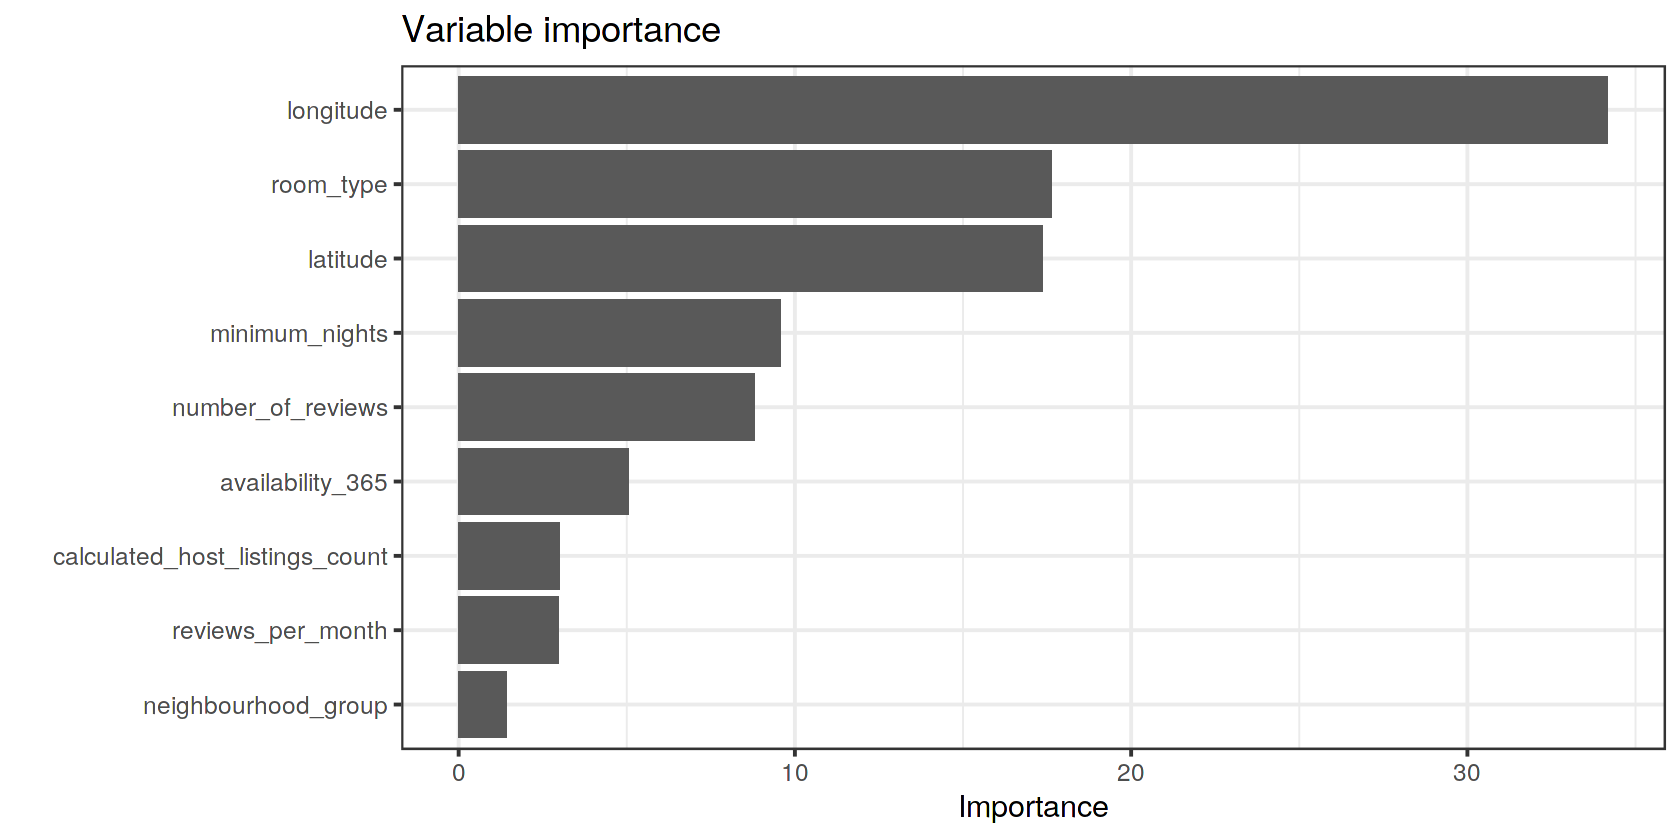

In [118]:
#-------------------------------------------------#
#######    Stochastic Gradient Boosting      ######
#-------------------------------------------------#

set.seed(123) # Stochastic Gradient Boosting
m.gbm <- gbm(price~., data=train,
                distribution = "gaussian", 
                verbose=FALSE,
                n.trees = 1000, 
                interaction.depth = 3, 
                shrinkage = 0.01,
                n.minobsinnode = 10);

#--------------------------------------------------#
######   Visualize the Varaible Importance    ######
#--------------------------------------------------#

options(repr.plot.width=14, repr.plot.height=7)
vip::vip(m.gbm) + theme_bw(base_size = 18) +
  labs(title = "Variable importance");

In [123]:
#--------------------------------#
####   k-Nearest Neighbour    ####
#--------------------------------#

library(kknn)
set.seed(123) 
m.knn <- kknn(price ~., train, test, k = 9);

In [127]:
#-----------------------------------------------------#
####  Linear Regression with Stepwise Selection    ####
#-----------------------------------------------------#

set.seed(123)
m.leaps <- leaps(x = train.X.m, y = train.Y, nbest = 4);

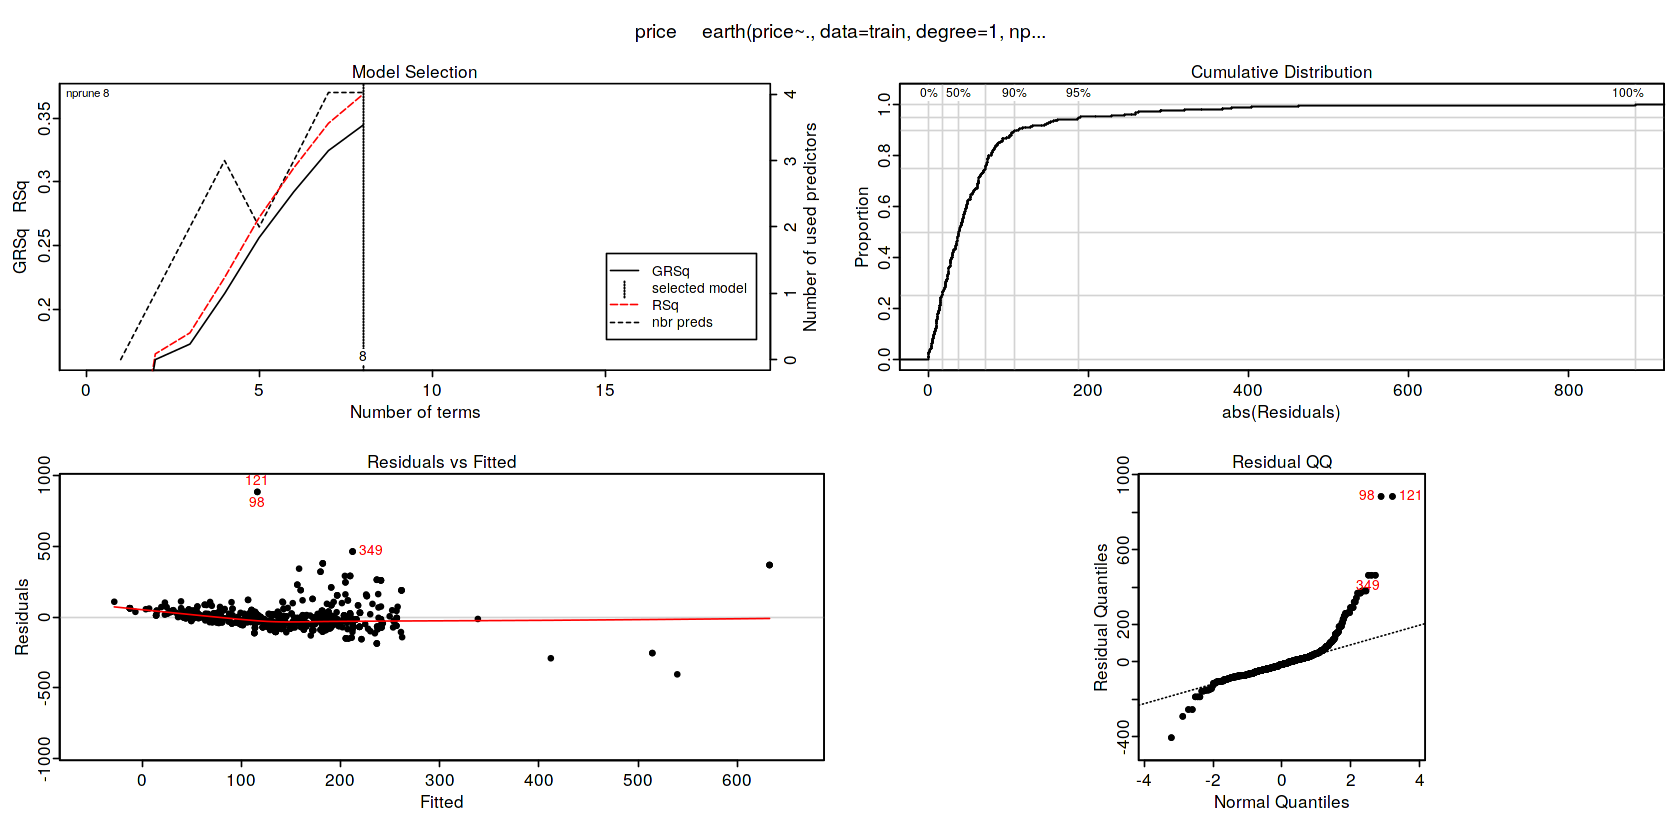

In [128]:
#----------------------------------------------------#
####   Multivariate Adaptive Regression Spline    ####
#----------------------------------------------------#

set.seed(123) 
m.earth <- earth(price ~., data = train, nprune = 8, degree = 1);

# visualize the model
plot(m.earth)

In [130]:
#-----------------------------------------------------------#
####   Bagged Multivariate Adaptive Regression Spline    ####
#-----------------------------------------------------------#

set.seed(123) 
m.bagEarth <- bagEarth(x = train.X.m, y = train.Y, 
                          nprune = 8, degree = 1);

In [134]:
#------------------------------------------#
#######        Ridge Regression       ######
#------------------------------------------#

# create the set of lambda values (will be powers of 10)
grid <- seq(10, -3, length=100);
lamVals <- 10 ^ grid

# fit the ridge regression model (alpha = 0 for ridge)

m.ridge <- glmnet(x = train.X.m, y = train.Y, alpha = 0, 
                     lambda = lamVals, standardize=TRUE)

#------------------------------------------------------------------------#
#####       Cross Validation for optimal lambda (for Prediction)    ######
#------------------------------------------------------------------------#

m_cv_ridge <- cv.glmnet(x = train.X.m, y = train.Y, alpha = 0, 
                           lambda = lamVals, standardize=TRUE);


[1] 0.5722368

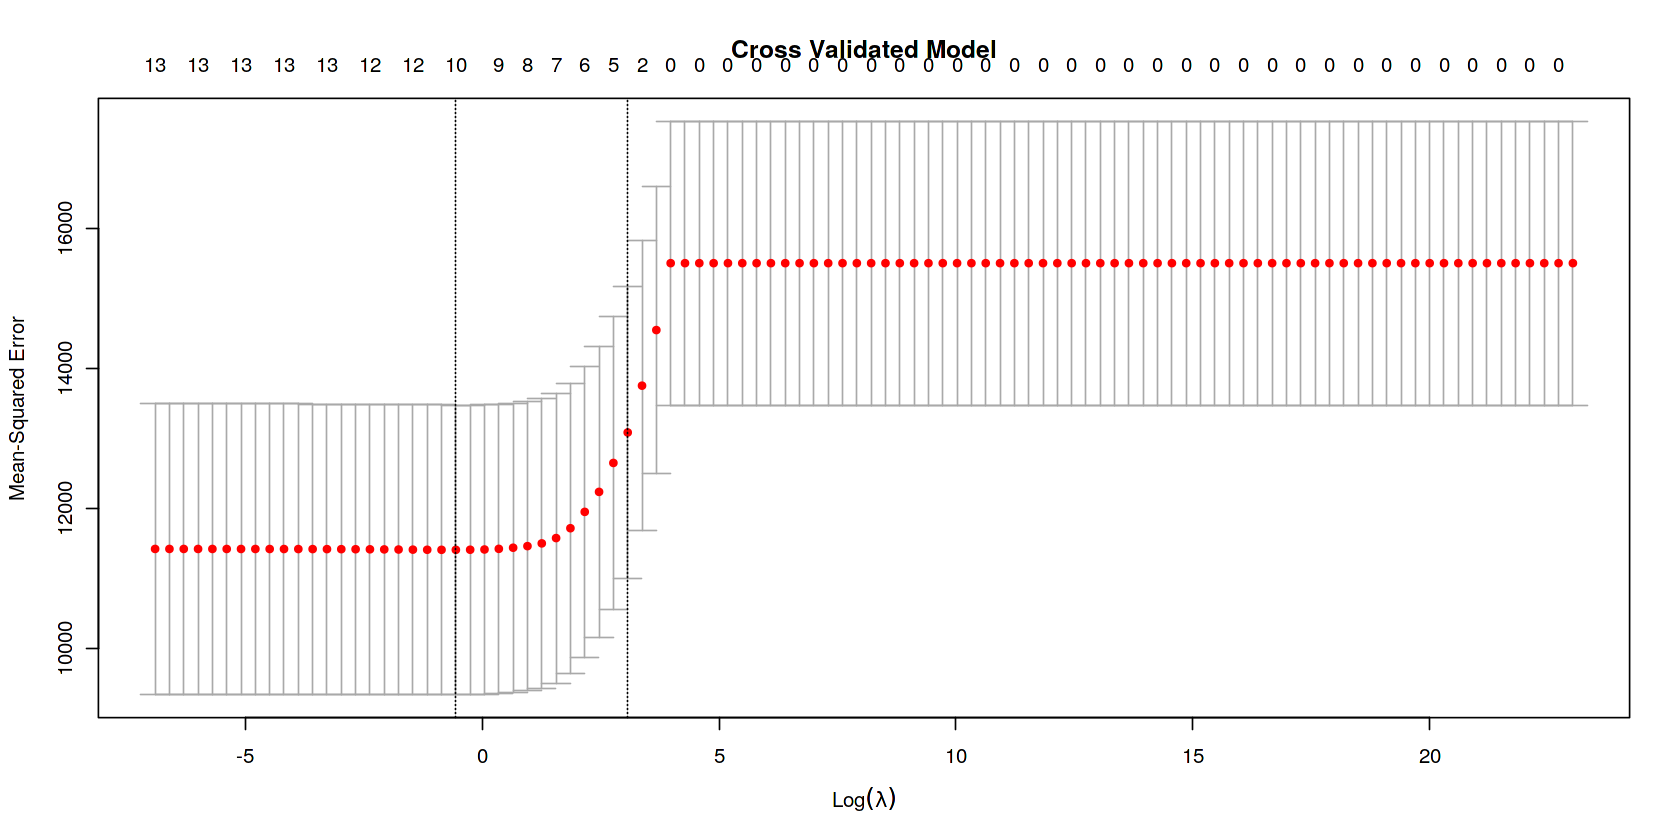

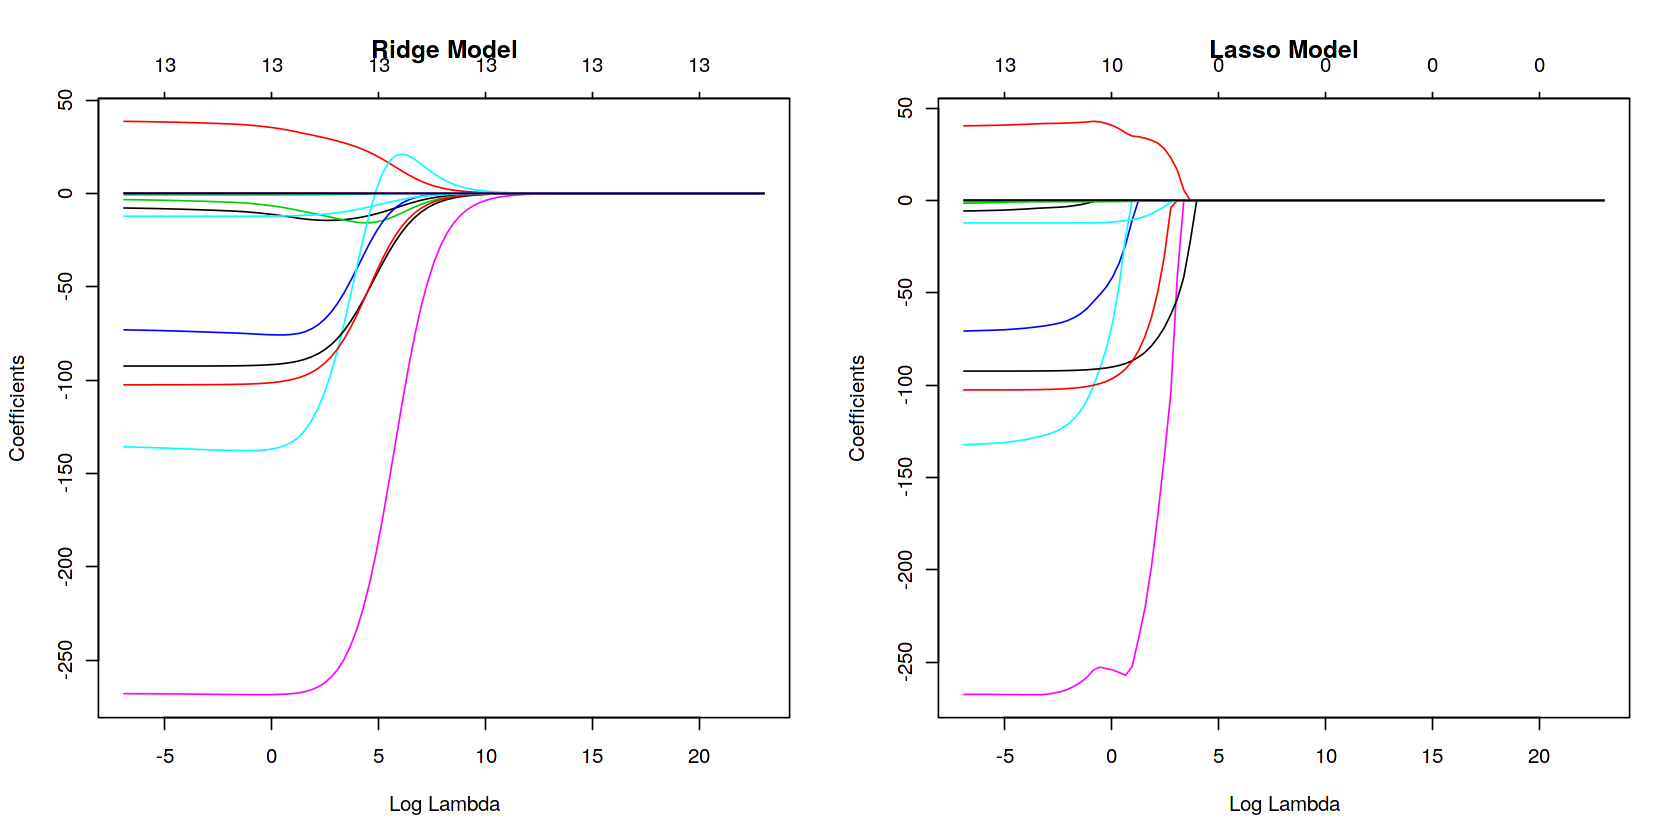

In [133]:
#------------------------------------------#
#######        Lasso Regression       ######
#------------------------------------------#

m.lasso <- glmnet(x = train.X.m, y = train.Y, alpha = 1, 
                     lambda = lamVals, standardize=TRUE)

#------------------------------------------------------------------------#
#####       Cross Validation for optimal lambda (for Prediction)    ######
#------------------------------------------------------------------------#

m_lasso <- cv.glmnet(x = train.X.m, y = train.Y, alpha = 1, 
                        lambda = lamVals, standardize=TRUE);

# Visualize the Cross Validation
plot(m_lasso, main = "Cross Validated Model")
# Predict with the optimal lambda = min lambda  
m_lasso$lambda.min;


#----------------------------------------------#
####   Visualize the Ridge & Lasso Models   ####
#----------------------------------------------#

par(mfrow = c(1,2))
plot(m.ridge, xvar = "lambda", main = "Ridge Model")
plot(m.lasso, xvar = "lambda", main = "Lasso Model")
par(mfrow = c(1,1))

In [137]:
#----------------------------------------------------#
######    Elastic-Net for Sparse Estimation     ######
#----------------------------------------------------#

m.enet <- enet(x = train.X.m, y = train.Y,
               normalize = T,
               lambda = 0.001);


In [136]:
#----------------------------------------------------------------------#
####   generalized linear model via penalized maximum likelihood    ####
#----------------------------------------------------------------------#


m.glmnet <- glmnet(x = train.X.m, y = train.Y, family="gaussian",
                 standardize = T,
                 lambda = 1.092196,
                 alpha = 0.5);

In [139]:
#---------------------------------------------------------------#
#######      Support Vector Machines with Linear Kernel    ######
#---------------------------------------------------------------#

m.svmLinear = svm(formula = price ~ ., data = train,
                  type = 'eps-regression', kernel = 'linear')

In [141]:
#-----------------------------------------------#
#######       Support Vector Machines      ######
#######   Radial Basis Function Kernel     ######
#-----------------------------------------------#

library(kernlab)

# Tuning parameters: sigma (Sigma) , C (Cost)
set.seed(123) # Support Vector Machines with Radial Basis Function Kernel
m.svmRadial <- ksvm(price ~ ., data = train, type = "eps-svr",
                       sigma = 0.04865976, C = 0.5, scaled = T);

In [142]:
#-------------------------------------------------#
#####   Tune the Model to Improve Accuracy    #####
#-------------------------------------------------#

# using 10 fold Cross Validation
m.tune.1 <- tune(svm, price ~ ., data = train, 
                    ranges = list(gamma = 2^(-1:1), cost = 2^(2:4)),
                    tunecontrol = tune.control(sampling = "fix"))
# gamma as a sequence = seq(0.001, 1, length = 10)
m.tune.2 <- tune(svm, price ~ ., data = train, 
                    ranges = list(gamma = seq(0.001, 1, length = 10), cost = 2^(2:4)),
                    tunecontrol = tune.control(sampling = "fix"))

In [144]:
#---------------------------------------------#
####     Support Vector Tuned Models      #####
#---------------------------------------------#


m.SVMtun.1 = svm(formula = price ~ ., data = train,
                    type = 'eps-regression',
                    kernel = 'radial',
                    gamma = 0.5, epsilon = 0.1, 
                    cost = 4)


m.SVMtun.2 = svm(formula = price ~ ., data = train,
                    type = 'eps-regression',
                    kernel = 'radial',
                    gamma = 0.445, epsilon = 0.1, 
                    cost = 16)

In [146]:
##########################################################
#--------------------------------------------------------#
######        Predicting the Test set results        #####
#--------------------------------------------------------#
##########################################################


y.pred.lm = predict(m.lm, newdata = x_test);
y.pred.mvr = predict(m.mvr, newdata = x_test, type = "response", ncomp = 3);
y.pred.blackboost = predict(m.blackboost, newdata = x_test, type = "response");
y.pred.rpart = predict(m.rpart, newdata = x_test, type = "vector");
y.pred.rpart.prn = predict(m.rpart.prn, newdata = x_test, type = "vector");
y.pred.ctree = predict(m.ctree, newdata = x_test);
y.pred.cforest= predict(m.cforest, newdata = x_test);
y.pred.treebag = predict(m.treebag, newdata = x_test);
y.pred.randomForest = predict(m.randomForest, newdata = x_test);
y.pred.gam = predict(m.gam, newdata = x_test);
y.pred.gam.spline = predict(m.gam.spline, newdata = x_test);
y.pred.gbm  = predict(m.gbm, newdata = x_test, n.trees = 1000);
#y.pred.cubist = predict(m.cubist, newdata = test.X.m, neighbors = 5);
y.pred.knn = predict(m.knn, newdata = x_test, neighbors = 5);
# y.pred.leaps = predict(m.leaps, newdata = test.X.m);
y.pred.earth = predict(m.earth, newdata = x_test);
y.pred.bagEarth = predict(m.bagEarth, newdata = test.X.m);
y.pred.ridge = predict(m.ridge, s = m_cv_ridge$lambda.min,
                        newx = test.X.m);
y.pred.lasso = predict(m.lasso, s = m_lasso$lambda.min,
                        newx = test.X.m);
#y.pred.enet = as.vector(predict(m.enet, newx = test.X.m));
y.pred.glmnet = predict(m.glmnet, newx = test.X.m, type = "response");
y.pred.svmLinear = predict(m.svmLinear, newdata = x_test);
y.pred.svmRadial = predict(m.svmRadial, newdata = x_test);
y.pred.SVMtun.1 = predict(m.SVMtun.1, newdata = x_test);
y.pred.SVMtun.2 = predict(m.SVMtun.2, newdata = x_test);



#-----------------------------------------------#
######          Mean Absolute Error        ######
#-----------------------------------------------#

MAE.lm = round(caret::MAE(y.pred.lm, y_test),3);
MAE.mvr = round(caret::MAE(y.pred.mvr, y_test),3);
MAE.blackboost = round(caret::MAE(y.pred.blackboost, y_test),3);
MAE.rpart = round(caret::MAE(y.pred.rpart, y_test),3);
MAE.rpart.prn = round(caret::MAE(y.pred.rpart.prn, y_test),3);
MAE.ctree = round(caret::MAE(y.pred.ctree, y_test),3);
MAE.cforest = round(caret::MAE(y.pred.cforest, y_test),3);
MAE.treebag = round(caret::MAE(y.pred.treebag, y_test),3);
MAE.randomForest = round(caret::MAE(y.pred.randomForest, y_test),3);
MAE.gam = round(caret::MAE(y.pred.gam, y_test),3);
MAE.gam.spline = round(caret::MAE(y.pred.gam.spline, y_test),3);
MAE.gbm = round(caret::MAE(y.pred.gbm,  y_test),3);
#MAE.cubist = round(caret::MAE(y.pred.cubist, y_test),3);
MAE.knn = round(caret::MAE(y.pred.knn, y_test),3);
# y.pred.leaps = predict(m.leaps, newdata = test.X.m);
MAE.earth = round(caret::MAE(y.pred.earth, y_test),3);
MAE.bagEarth = round(caret::MAE(y.pred.bagEarth, y_test), 3);
MAE.ridge = round(caret::MAE(y.pred.ridge, y_test),3);
MAE.lasso = round(caret::MAE(y.pred.lasso, y_test),3);
#MAE.enet = round(caret::MAE(y.pred.enet, y_test),3);
MAE.glmnet = round(caret::MAE(y.pred.glmnet, y_test),3);
MAE.svmLinear = round(caret::MAE(y.pred.svmLinear, y_test),3);
MAE.svmRadial = round(caret::MAE(y.pred.svmRadial, y_test),3);
MAE.SVMtun.1 = round(caret::MAE(y.pred.SVMtun.1, y_test),3);
MAE.SVMtun.2 = round(caret::MAE(y.pred.SVMtun.2,y_test), 3);

In [147]:
#-----------------------------------------------# 
######       Root Mean Squared Error       ######
#-----------------------------------------------#

RMSE.lm = round(caret::RMSE(y.pred.lm, y_test),3);
RMSE.mvr = round(caret::RMSE(y.pred.mvr, y_test),3);
RMSE.blackboost = round(caret::RMSE(y.pred.blackboost, y_test),3);
RMSE.rpart = round(caret::RMSE(y.pred.rpart, y_test),3);
RMSE.rpart.prn = round(caret::RMSE(y.pred.rpart.prn, y_test),3);
RMSE.ctree = round(caret::RMSE(y.pred.ctree, y_test),3);
RMSE.cforest = round(caret::RMSE(y.pred.cforest, y_test),3);
RMSE.treebag = round(caret::RMSE(y.pred.treebag, y_test),3);
RMSE.randomForest = round(caret::RMSE(y.pred.randomForest, y_test),3);
RMSE.gam = round(caret::RMSE(y.pred.gam, y_test),3);
RMSE.gam.spline = round(caret::RMSE(y.pred.gam.spline, y_test),3);
RMSE.gbm = round(caret::RMSE(y.pred.gbm,  y_test),3);
#RMSE.cubist = round(caret::RMSE(y.pred.cubist, y_test),3);
RMSE.knn = round(caret::RMSE(y.pred.knn, y_test),3);
# y.pred.leaps = predict(m.leaps, newdata = test.X.m);
RMSE.earth = round(caret::RMSE(y.pred.earth, y_test),3);
RMSE.bagEarth = round(caret::RMSE(y.pred.bagEarth, y_test), 3);
RMSE.ridge = round(caret::RMSE(y.pred.ridge, test.Y),3);
RMSE.lasso = round(caret::RMSE(y.pred.lasso, test.Y),3);
#RMSE.enet = round(caret::RMSE(y.pred.enet, test.Y),3);
RMSE.glmnet = round(caret::RMSE(y.pred.glmnet, test.Y),3);
RMSE.svmLinear = round(caret::RMSE(y.pred.svmLinear, y_test),3);
RMSE.svmRadial = round(caret::RMSE(y.pred.svmRadial, y_test),3);
RMSE.SVMtun.1 = round(caret::RMSE(y.pred.SVMtun.1, y_test),3);
RMSE.SVMtun.2 = round(caret::RMSE(y.pred.SVMtun.2,y_test), 3);


#-----------------------------------------------# 
######              R-Squared              ######
#-----------------------------------------------# 

R2.lm = round(caret::R2(y.pred.lm, y_test),3);
R2.mvr = round(caret::R2(y.pred.mvr, y_test),3);
R2.blackboost = round(caret::R2(y.pred.blackboost, y_test),3);
R2.rpart = round(caret::R2(y.pred.rpart, y_test),3);
R2.rpart.prn = round(caret::R2(y.pred.rpart.prn, y_test),3);
R2.ctree = round(caret::R2(y.pred.ctree, y_test),3);
R2.cforest = round(caret::R2(y.pred.cforest, y_test),3);
R2.treebag = round(caret::R2(y.pred.treebag, y_test),3);
R2.randomForest = round(caret::R2(y.pred.randomForest, y_test),3);
R2.gam = round(caret::R2(y.pred.gam, y_test),3);
R2.gam.spline = round(caret::R2(y.pred.gam.spline, y_test),3);
R2.gbm = round(caret::R2(y.pred.gbm,  y_test),3);
#R2.cubist = round(caret::R2(y.pred.cubist, y_test),3);
R2.knn = round(caret::R2(y.pred.knn, y_test),3);
#R2.leaps = round(caret::R2(y.pred.leaps, y_test),3);
R2.earth = round(caret::R2(y.pred.earth, y_test),3);
R2.bagEarth = round(caret::R2(y.pred.bagEarth, y_test), 3);
R2.ridge = round(caret::R2(y.pred.ridge, y_test),3);
R2.lasso = round(caret::R2(y.pred.lasso, y_test),3);
# R2.enet = round(caret::R2(y.pred.enet, y_test),3);
R2.glmnet = round(caret::R2(y.pred.glmnet, y_test),3);
R2.svmLinear = round(caret::R2(y.pred.svmLinear, y_test),3);
R2.svmRadial = round(caret::R2(y.pred.svmRadial, y_test),3);
R2.SVMtun.1 = round(caret::R2(y.pred.SVMtun.1, y_test),3);
R2.SVMtun.2 = round(caret::R2(y.pred.SVMtun.2,y_test), 3);



In [149]:
#------------------------------------------#
######   Compare Model Performance     #####
#------------------------------------------#

Model <- c("m.lm",
           "m.mvr",
           "m.blackboost",
           "m.rpart",
           "m.rpart.prn",
           "m.ctree",
           "m.cforest",
           "m.treebag",
           "m.randomForest",
           "m.gam",
           "m.gam.spline",
           "m.gbm",
           #"m.cubist",
           "m.knn",
              # "m.leaps",
           "m.earth",
           "m.bagEarth",
           "m.ridge",
           "m.lasso",
              # "m.enet",
           "m.glmnet",
           "m.svmLinear",
           "m.svmRadial",
           "m.SVMtun.1",
           "m.SVMtun.2")

Model.MAE = c(MAE.lm,
              MAE.mvr,
              MAE.blackboost,
              MAE.rpart,
              MAE.rpart.prn,
              MAE.ctree,
              MAE.cforest,
              MAE.treebag,
              MAE.randomForest,
              MAE.gam,
              MAE.gam.spline,
              MAE.gbm,
              #MAE.cubist, 
              MAE.knn,
              # MAE.leaps,
              MAE.earth,
              MAE.bagEarth,
              MAE.ridge,
              MAE.lasso,
              # MAE.enet,
              MAE.glmnet,
              MAE.svmLinear,
              MAE.svmRadial,
              MAE.SVMtun.1,
              MAE.SVMtun.2)


Model.RMSE <- c(RMSE.lm,
                RMSE.mvr,
                RMSE.blackboost,
                RMSE.rpart,
                RMSE.rpart.prn,
                RMSE.ctree,
                RMSE.cforest,
                RMSE.treebag,
                RMSE.randomForest,
                RMSE.gam,
                RMSE.gam.spline,
                RMSE.gbm,
                #RMSE.cubist,
                RMSE.knn,
                #RMSE.leaps,
                RMSE.earth,
                RMSE.bagEarth,
                RMSE.ridge,
                RMSE.lasso,
                #RMSE.enet,
                RMSE.glmnet,
                RMSE.svmLinear,
                RMSE.svmRadial,
                RMSE.SVMtun.1,
                RMSE.SVMtun.2)


Model.R2 <- c(R2.lm,
              R2.mvr,
              R2.blackboost,
              R2.rpart,
              R2.rpart.prn,
              R2.ctree,
              R2.cforest,
              R2.treebag,
              R2.randomForest,
              R2.gam,
              R2.gam.spline,
              R2.gbm,
              #R2.cubist,
              R2.knn,
              #R2.leaps,
              R2.earth,
              R2.bagEarth,
              R2.ridge,
              R2.lasso,
              #R2.enet,
              R2.glmnet,
              R2.svmLinear,
              R2.svmRadial,
              R2.SVMtun.1,
              R2.SVMtun.2)

# combine all into a data frame
mpc <- cbind.data.frame(Model, Model.MAE, Model.RMSE, Model.R2); mpc
mpc$Model <- as.factor(mpc$Model);
mpc %>% glimpse()


Model,Model.MAE,Model.RMSE,Model.R2
<fct>,<dbl>,<dbl>,<dbl>
m.lm,61.253,103.068,0.238
m.mvr,56.173,99.319,0.292
m.blackboost,49.799,87.338,0.456
m.rpart,48.603,81.350,0.530
m.rpart.prn,23.700,54.449,0.787
m.ctree,43.122,82.851,0.509
m.cforest,40.503,77.708,0.580
m.treebag,44.873,77.144,0.587
m.randomForest,31.014,63.373,0.734


Rows: 22
Columns: 4
$ Model      <fct> m.lm, m.mvr, m.blackboost, m.rpart, m.rpart.prn, m.ctree, …
$ Model.MAE  <dbl> 61.253, 56.173, 49.799, 48.603, 23.700, 43.122, 40.503, 44…
$ Model.RMSE <dbl> 103.068, 99.319, 87.338, 81.350, 54.449, 82.851, 77.708, 7…
$ Model.R2   <dbl> 0.238, 0.292, 0.456, 0.530, 0.787, 0.509, 0.580, 0.587, 0.…


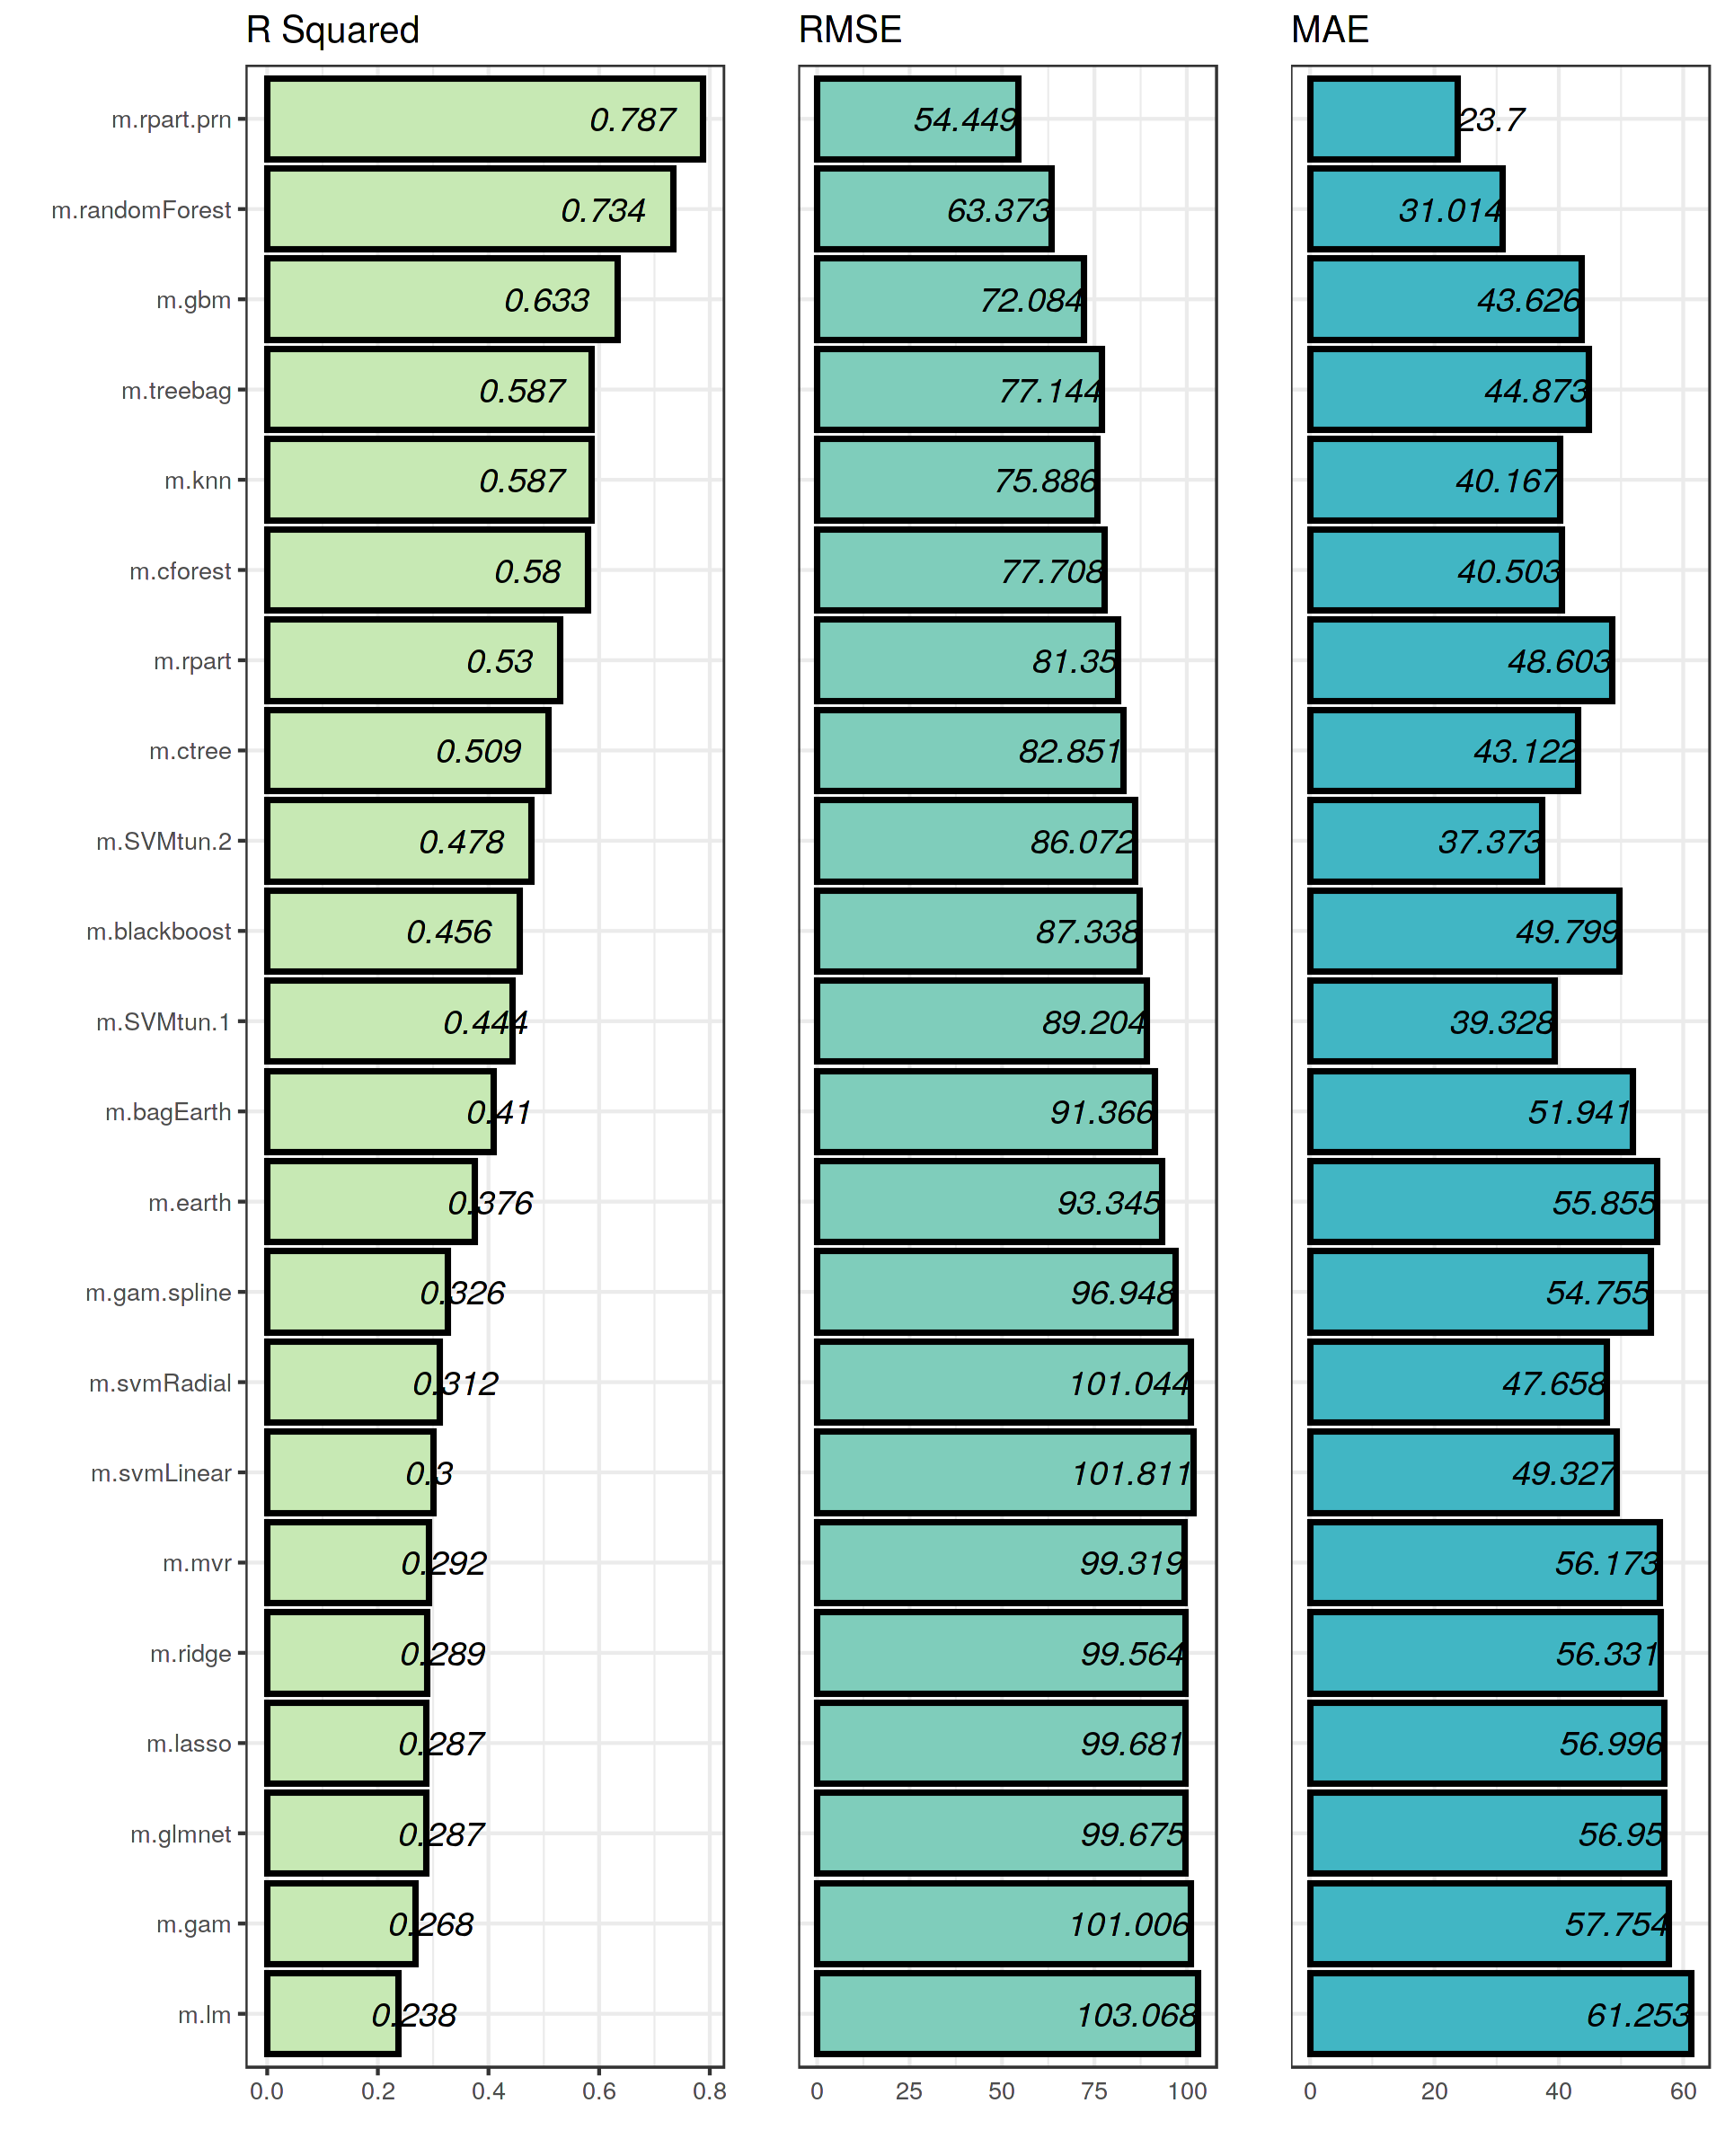

In [157]:
#################################################
#-----------------------------------------------#
######       Final Model Comparisons        ##### 
#-----------------------------------------------#
#################################################

library(forcats) # to order the columns

a = ggplot(mpc, aes(x = fct_reorder(Model, Model.R2), Model.R2))  +
  geom_bar(stat = "identity", fill = "#C7E9B4", col = "black", lwd = 1.5) +
  theme_bw(base_size = 20) + labs(title = "R Squared",  x = "", y = "") +
  geom_text(aes(label=Model.R2), hjust="inward", nudge_y = -0.05,
            color="black", size=8, fontface = "italic") + coord_flip()

b = ggplot(mpc, aes(x = fct_reorder(Model, Model.R2), Model.RMSE))  +
  geom_bar(stat = "identity", fill = "#7FCDBB", col = "black", lwd = 1.5) +
  theme_bw(base_size = 20) + labs(title = "RMSE",  x = "", y = "") +
  geom_text(aes(label=Model.RMSE), hjust="inward",  nudge_y = -0.05,
            color="black", size=8, fontface = "italic") + coord_flip() +
  theme(axis.text.y=element_blank(),axis.ticks=element_blank())

c = ggplot(mpc, aes(x = fct_reorder(Model, Model.R2), Model.MAE)) +
  geom_bar(stat = "identity", fill = "#41B6C4", col = "black", lwd = 1.5) +
  theme_bw(base_size = 20) + labs(title = "MAE", x = "", y = "") +
  geom_text(aes(label=Model.MAE), hjust="inward",  nudge_y = -0.05,
            color="black", size=8, fontface = "italic") + coord_flip() +
  theme(axis.text.y=element_blank(),axis.ticks=element_blank())

options(repr.plot.width=16, repr.plot.height=20)
plot_grid(a,b,c, ncol = 3, nrow = 1,
          rel_widths = c(1.5,1,1))

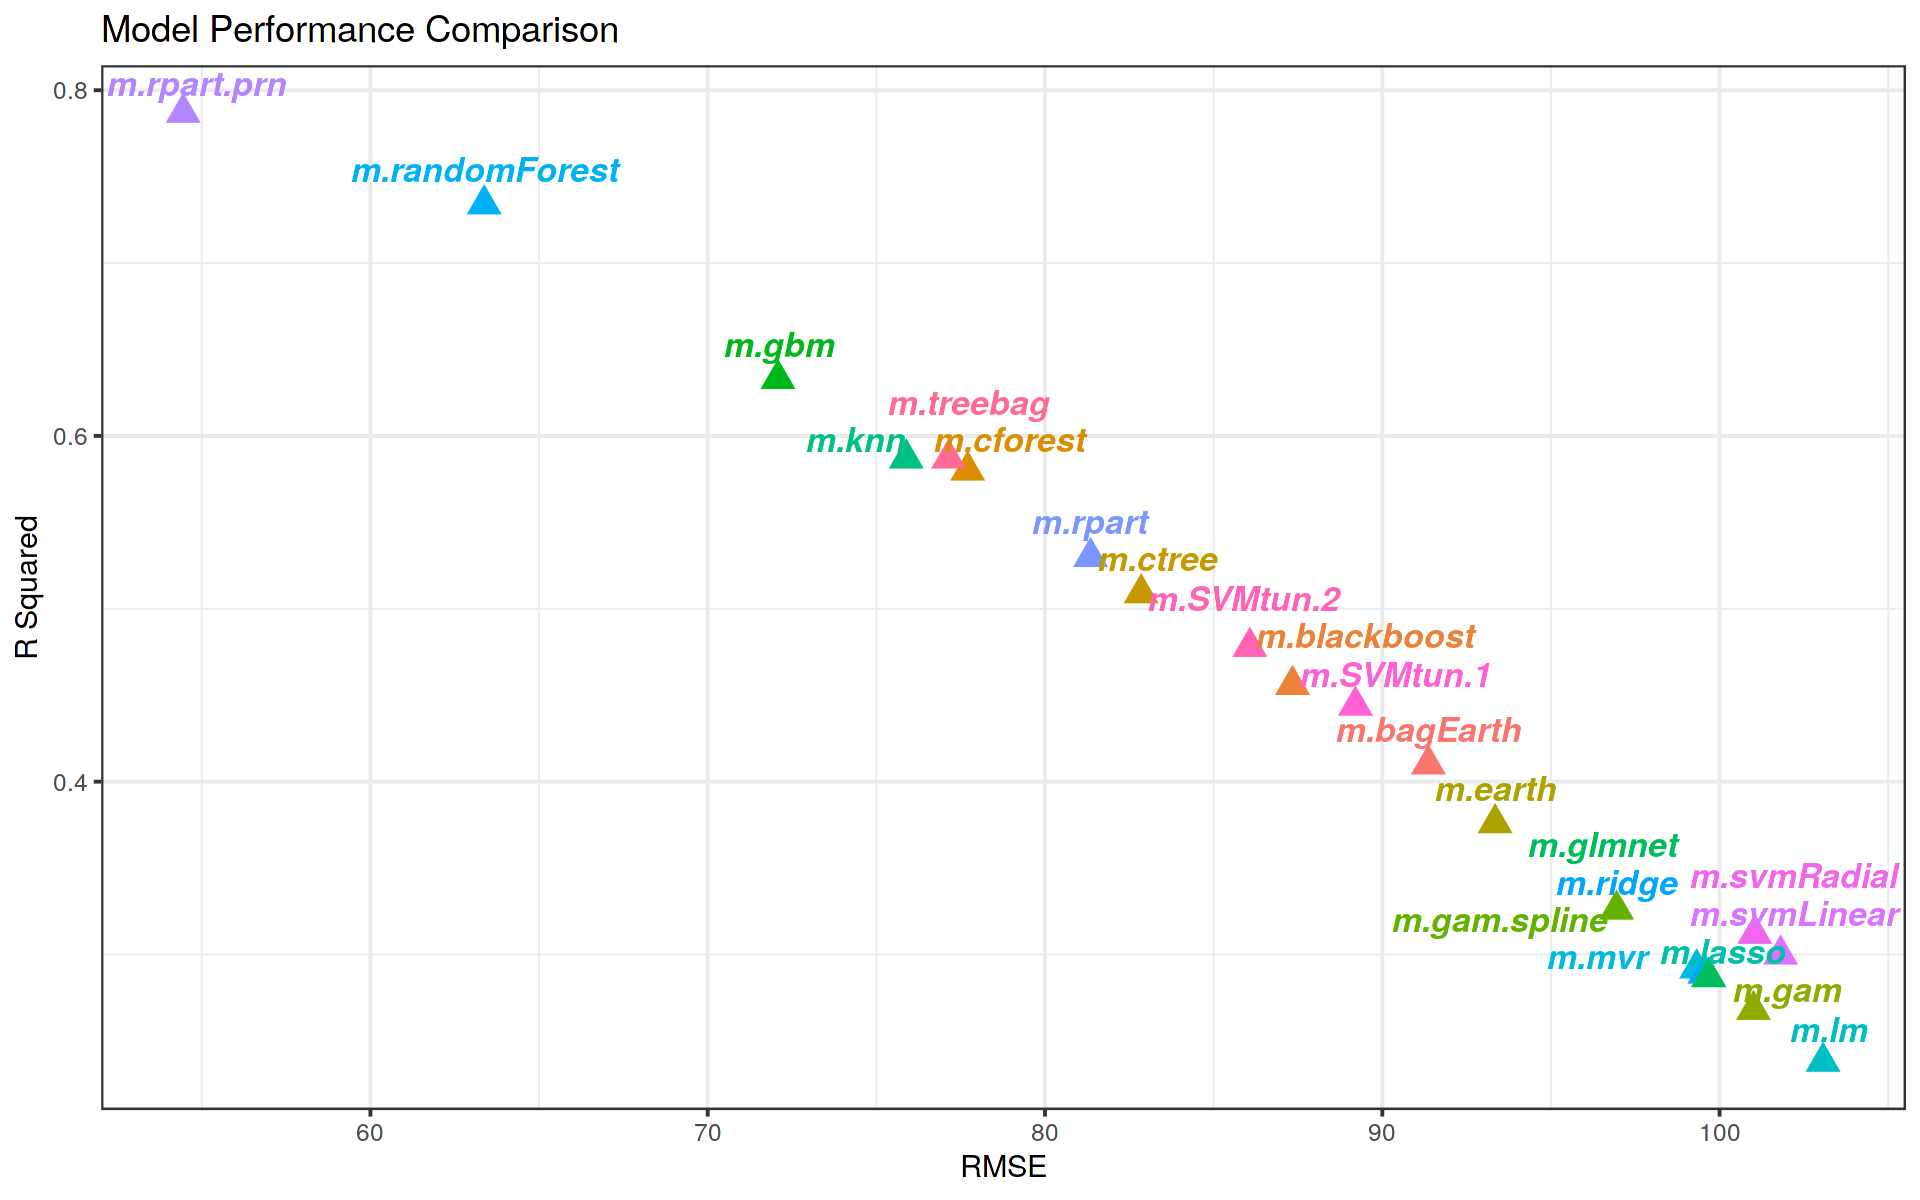

In [155]:
#---------------------------------------------#
####   Scatter plot of Model Performance   ####
#---------------------------------------------#

library(ggrepel)
options(repr.plot.width=16, repr.plot.height=10)
ggplot(mpc, aes(Model.RMSE, Model.R2, label = Model, color = Model)) + 
  geom_point(show.legend = F, pch = 17, size = 4, stroke = 5) + 
  geom_text_repel(show.legend = F, size = 7, nudge_y = 0.02, nudge_x = 0.03, 
                  segment.color = NA, fontface = "bold.italic") + 
  theme_bw(base_size = 18) + # ylim(0.4, 0.8) +
  labs(title = "Model Performance Comparison", x = "RMSE", y = "R Squared") 
